In [1]:
library(data.table)
library(ggplot2)
library(reshape2)
library(tidyverse)
library(stringr)
library(heatmaply)
library(ape)
library(phylogram)
library(dendextend)
library(ComplexHeatmap)
library(RColorBrewer)
library(circlize)
library('stringr')
library(ggthemes)
library(ggpubr)
library(matrixStats)


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: plotly


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: viridis

Loading r

In [2]:
lorikeet_funct <- function(a){
    
    a$attributes <- paste(a$attributes, ";", sep="")

    a$indels <- str_match(a$attributes, "indels=\\s*(.*?)\\s*;")[,2]
    a$rbs_spacer <- str_match(a$attributes, "rbs_spacer=\\s*(.*?)\\s*;")[,2]
    a$snps <- str_match(a$attributes, "snps=\\s*(.*?)\\s*;")[,2]
    a$dN_dS <- str_match(a$attributes, "dN/dS=\\s*(.*?)\\s*;")[,2]
    a$start_type <- str_match(a$attributes, "start_type=\\s*(.*?)\\s*;")[,2]
    a$uscore <- str_match(a$attributes, "uscore=\\s*(.*?)\\s*;")[,2]
    a$partial <- str_match(a$attributes, "partial=\\s*(.*?)\\s*;")[,2]
    a$conf <- str_match(a$attributes, "conf=\\s*(.*?)\\s*;")[,2]
    a$bs_motif <- str_match(a$attributes, "bs_motif=\\s*(.*?)\\s*;")[,2]
    a$gc_cont <- str_match(a$attributes, "gc_cont=\\s*(.*?)\\s*;")[,2]
    a$cscore <- str_match(a$attributes, "cscore=\\s*(.*?)\\s*;")[,2]
    a$ID <- str_match(a$attributes, "ID=\\s*(.*?)\\s*;")[,2]
    a$score <- str_match(a$attributes, "score=\\s*(.*?)\\s*;")[,2]
    a$rscore <- str_match(a$attributes, "rscore=\\s*(.*?)\\s*;")[,2]
    a$tscore <- str_match(a$attributes, "tscore=\\s*(.*?)\\s*;")[,2]
    a$sscore <- str_match(a$attributes, "sscore=\\s*(.*?)\\s*;")[,2]
    
    a$dN_dS <- sub('\\]', '', a$dN_dS)
    a$dN_dS <- sub('\\[', '', a$dN_dS)
    
    a$snps <- sub('\\]', '', a$snps)
    a$snps <- sub('\\[', '', a$snps)
        
    a$indels <- sub('\\]', '', a$indels)
    a$indels <- sub('\\[', '', a$indels)

    a2 <- subset(a, select=-c(attributes))
    
    return(a2)
}

prok_funct <- function(b){
    
    b$attributes <- paste(b$attributes, ";", sep="")
    b$ID <- str_match(b$attributes, "ID=\\s*(.*?)\\s*;")[,2]
    b$inference <- str_match(b$attributes, "inference=\\s*(.*?)\\s*;")[,2]
    b$locus_tag <- str_match(b$attributes, "locus_tag=\\s*(.*?)\\s*;")[,2]
    b$product <- str_match(b$attributes, "product=\\s*(.*?)\\s*;")[,2]

    b2 <- subset(b, select=-c(attributes))
    
    return(b2)
}

common_variables <- c('seqid','start','end','strand', 'phase')

In [3]:
# function to make the wide snps matricies 
# gene name and location 

split_function <- function(snps, tsv, pos_min=1.05, neg_max=0.95){ 
    colnames(snps) <- c(1:208,"locus_tag")
    snps3 <- merge(snps, tsv, by="locus_tag", all.y=FALSE)

    snps3$gene_loc <- paste(snps3$locus_tag, snps3$gene)
    snps4 <- snps3 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    snps5 <- snps4[,2:209]

    snps5$mean <- apply(snps5, 1, mean, na.rm=TRUE)
    snps5$min <- rowMins(as.matrix(snps5[,2:209]))
    snps5$max <- rowMaxs(as.matrix(snps5[,2:209]))
    snps5$pos <- rowSums(as.matrix(snps5[,2:209]) >= pos_min)
    snps5$neg <- rowSums(as.matrix(snps5[,2:209]) <= neg_max)
    
    return(snps5)
}

In [4]:
# product and location 

split_function4 <- function(snps, tsv, pos_min=1.05, neg_max=0.95){ 
    colnames(snps) <- c(1:208,"locus_tag")
    snps3 <- merge(snps, tsv, by="locus_tag", all.y=FALSE)

    snps3$gene_loc <- paste(snps3$locus_tag, snps3$product)
    snps4 <- snps3 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    snps5 <- snps4[,2:209]

    snps5$mean <- apply(snps5, 1, mean, na.rm=TRUE)
    snps5$min <- rowMins(as.matrix(snps5[,2:209]))
    snps5$max <- rowMaxs(as.matrix(snps5[,2:209]))
    snps5$pos <- rowSums(as.matrix(snps5[,2:209]) >= pos_min)
    snps5$neg <- rowSums(as.matrix(snps5[,2:209]) <= neg_max)
    
    return(snps5)
}

In [5]:
#import the ko enrichm file 
main_dir <- "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/"

ko <- fread(paste0(main_dir, '09_methanoflorens/references/2022-05-09_09-29-enrichm_annotate_output/annotations_ko/DIAMOND_search.tsv'))
ko2 <- data.frame(do.call('rbind', strsplit(as.character(ko$V1),'~',fixed=TRUE)))
ko3 <- data.frame(do.call('rbind', strsplit(as.character(ko$V2),'~',fixed=TRUE)))
ko4 <- cbind(ko2,ko3)
ko4 <- cbind(ko4, ko[,3:12])

colnames(ko4)[1:4] <- c("genome",
                "locus_tag",
                "uniref",
                "ko")
ko5 <- ko4[,1:4]


In [190]:
# metadata[, 210]

In [6]:
# importing metadata
metadata <- fread(paste0(main_dir, "09_methanoflorens/20220504_ani_metadata.tsv")) # read in metadata with ANIs calculated in other jupyter
# metadata$type <- metadata$type %>% replace_na('none')
metadata$type <- metadata$type %>% replace_na('Other') %>% factor(level=c("Bog", "Fen", "Palsa", "Other"))
metadata$location <- metadata$location %>% replace_na('Other')
metadata[, order_col:=paste0(location, "_", type, "_", run)]

# making the annotations for the heatmaps

# location = HeatmapAnnotation(Location = metadata$location,
#     col = list(Location = c('Chersky'='#8DD3C7',
#                        'Other'='white',
#                        'Alaska'='#80B1D3',
#                        'Marcell'='#B3DE69',
#                        'Loxahatchee'='#FDB462',
#                        'Abisko'='#FB8072')))

location = HeatmapAnnotation(Location = metadata$location,
    col = list(Location = c('Abisko'='#8DD3C7',
                            'Alaska'='#FFFFB3',
                            'Chersky'='#BEBADA',
                            'Loxahatchee'='#FB8072',
                            'Marcell'='#80B1D3',
                            'Other'='#FDB462'))
                            )

# subhab = HeatmapAnnotation(Subhabitat = metadata$type,
#     col = list(Subhabitat = c('none'='white',
#                        'Palsa'='#2B83BA',
#                        'Bog'='#FDAE61',
#                        'Fen'='#D7191C')))


subhab = HeatmapAnnotation(Subhabitat = metadata$type,
    col = list(Subhabitat = c(
                        'Other' = '#FFFFFF',
                        'Palsa'='#703C1B',
                       'Bog'='#058000',
                       'Fen'='#0001FF'), na_col=NULL))

col_fun = colorRamp2(c(0,1), c("blue", "white"))
col_fun2 = colorRamp2(c(1,6), c("white", "red"))
col_fun3 = colorRamp2(c(0,1,6), c("blue", "white", "red"))



In [21]:
set2_con <- RColorBrewer::brewer.pal(name="Set3", n=6)
set2_con

[1] "#8DD3C7" "#FFFFB3" "#BEBADA" "#FB8072" "#80B1D3" "#FDB462"

In [7]:
# function for plotting heatmaps

heatmap_function <- function(df, colours, title, column_order=order(metadata$order_col)){
    plot <- Heatmap(df, col=colours,
                    name = "dN/dS", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 0),
                    bottom_annotation = c(subhab,location),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    column_title={{title}},
                    column_order=column_order 
               )
    return(plot)
    }

In [35]:
# head(e2d_low2)
# ncol(e2d_low2)
# class(e2d_low2)

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


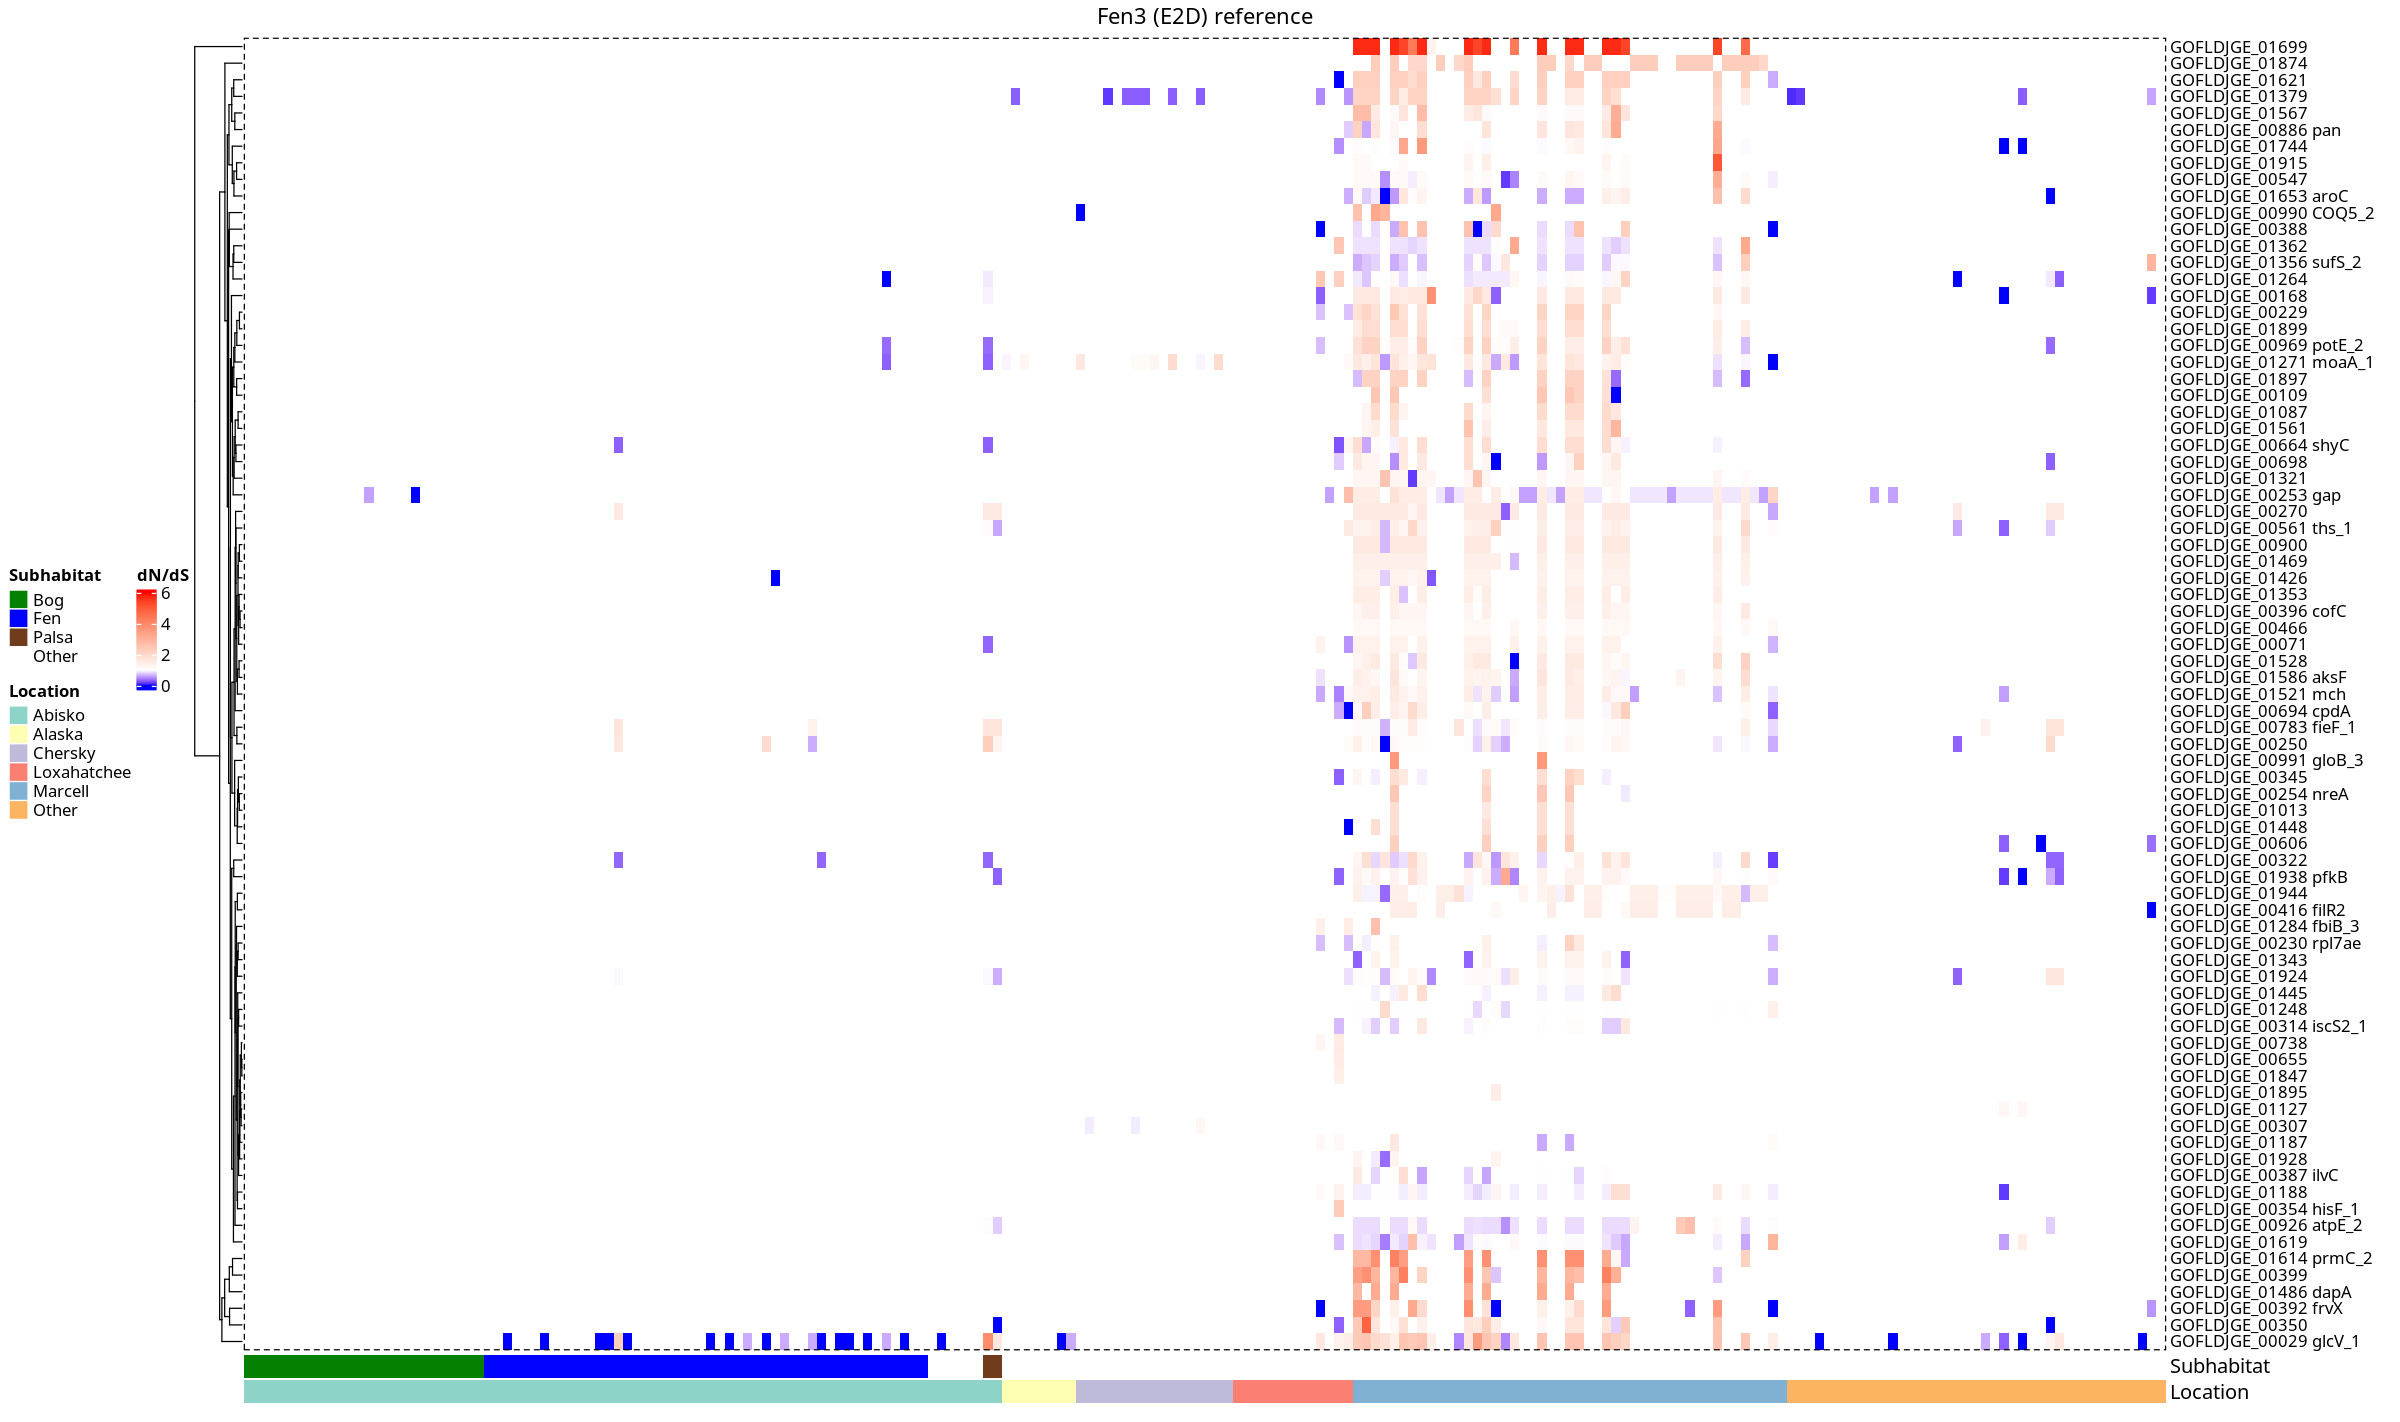

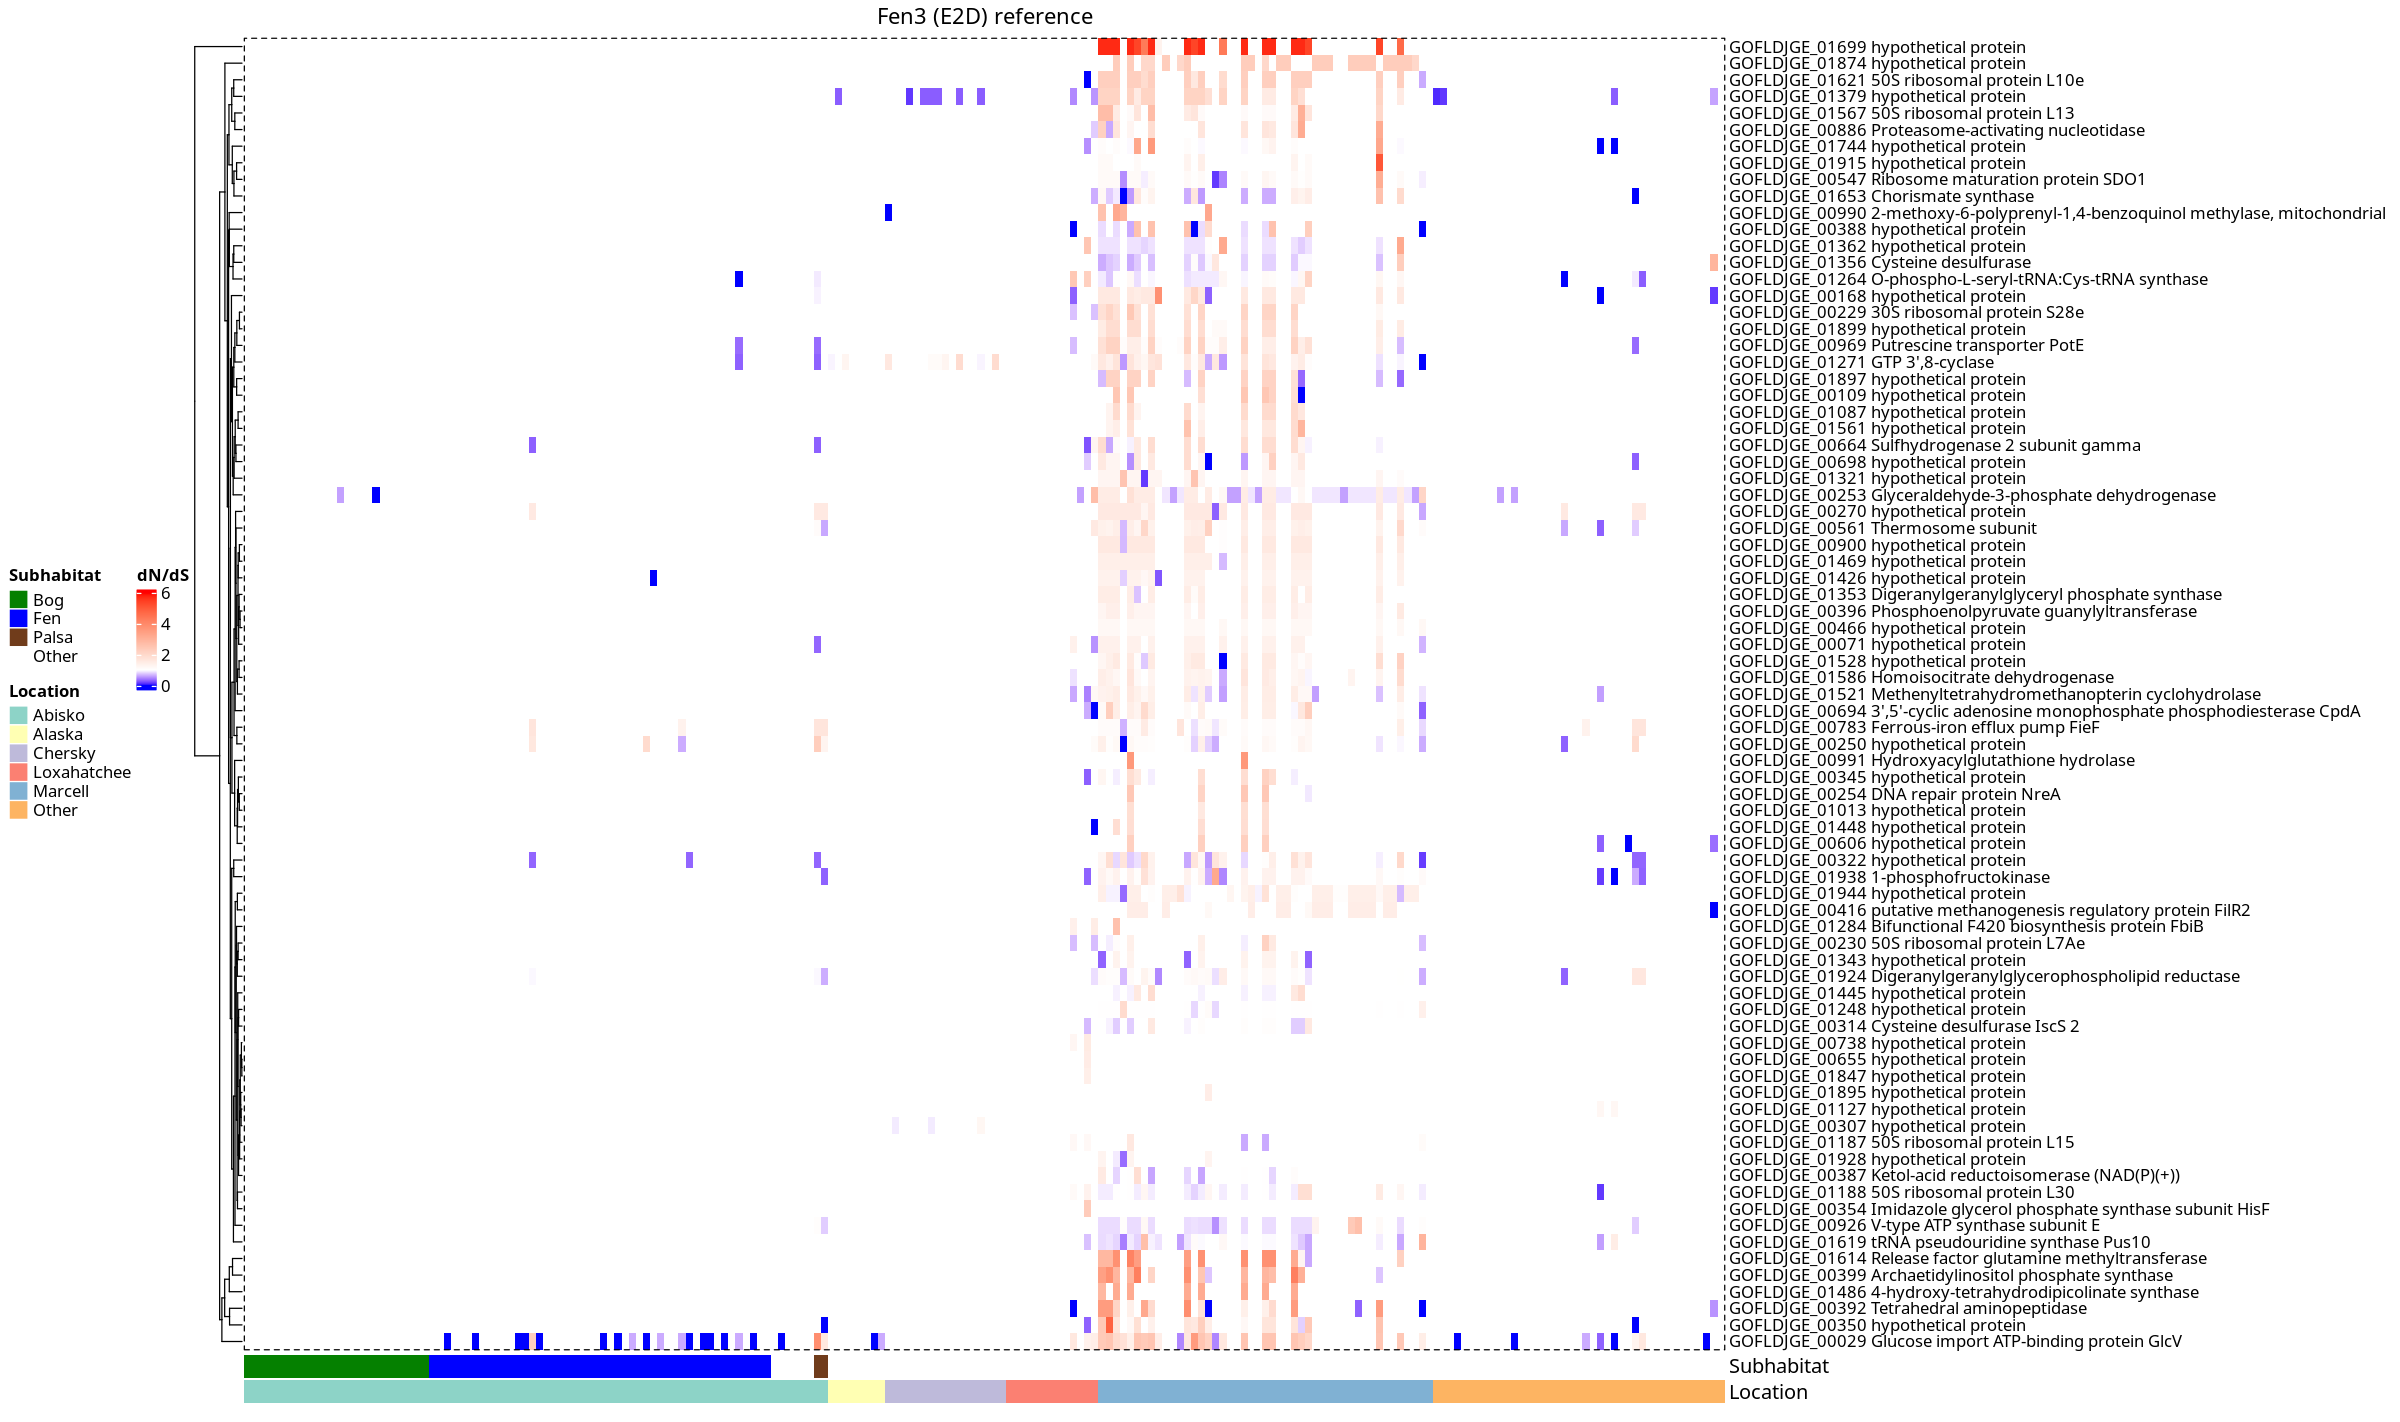

In [8]:
# full process dor e2d

prok_e2d <- read.gff(paste0(main_dir, '09_methanoflorens/references/prokka_e2d/clean_20100900_E2D.gff'))
lor_e2d <- read.gff(paste0(main_dir, '00-lorikeet_call/GCA_003162175.1_20100900_E2D_genomic/GCA_003162175.1_20100900_E2D_genomic.gff'))
e2d_tsv <- fread(paste0(main_dir, '09_methanoflorens/references/prokka_e2d/prokka_e2d.tsv'))

lorikeet_e2d <- lorikeet_funct(lor_e2d)
prokka_e2d <- prok_funct(prok_e2d)

comb_e2d <- merge(lorikeet_e2d, prokka_e2d, by=common_variables, all=FALSE) 

e2d_dnds <- data.frame(do.call('rbind', strsplit(as.character(comb_e2d$dN_dS),',',fixed=TRUE)))
e2d_dnds <- mutate_all(e2d_dnds, function(x) as.numeric(as.character(x)))
e2d_dnds$locus_tag <- comb_e2d$locus_tag
                       
e2d_dnds_filt <- e2d_dnds %>% 
    rowwise %>% 
    filter(sum(c_across(where(is.numeric))) != 208) %>%
    ungroup

e2d_matrix <- split_function(e2d_dnds_filt, e2d_tsv) #gene name and location
e2d_matrix2 <- split_function4(e2d_dnds_filt, e2d_tsv) #product and location 

# upper_boundary_e2d<- mean(e2d_matrix$mean)+(2*sd(e2d_matrix$mean))  

e2d_low <- subset(e2d_matrix, mean>1)[,1:208]           
e2d_all <- e2d_matrix[,1:208]
                       
e2d_low2 <- subset(e2d_matrix2, mean>1)[,1:208]           
e2d_all2 <- e2d_matrix2[,1:208]
                       
# h1 <- 0.05*nrow(e2d_all)
# options(repr.plot.width=20, repr.plot.height=h1)
# hma <- heatmap_function(e2d_all, col_fun3,"Fen3 (E2D) reference")
# draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
h1 <- 0.15*nrow(e2d_low)
options(repr.plot.width=20, repr.plot.height=h1)
hma <- heatmap_function(e2d_low, col_fun3,"Fen3 (E2D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
hma2 <- heatmap_function(e2d_low2, col_fun3,"Fen3 (E2D) reference")
draw(hma2, heatmap_legend_side = "left", annotation_legend_side = "left")

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


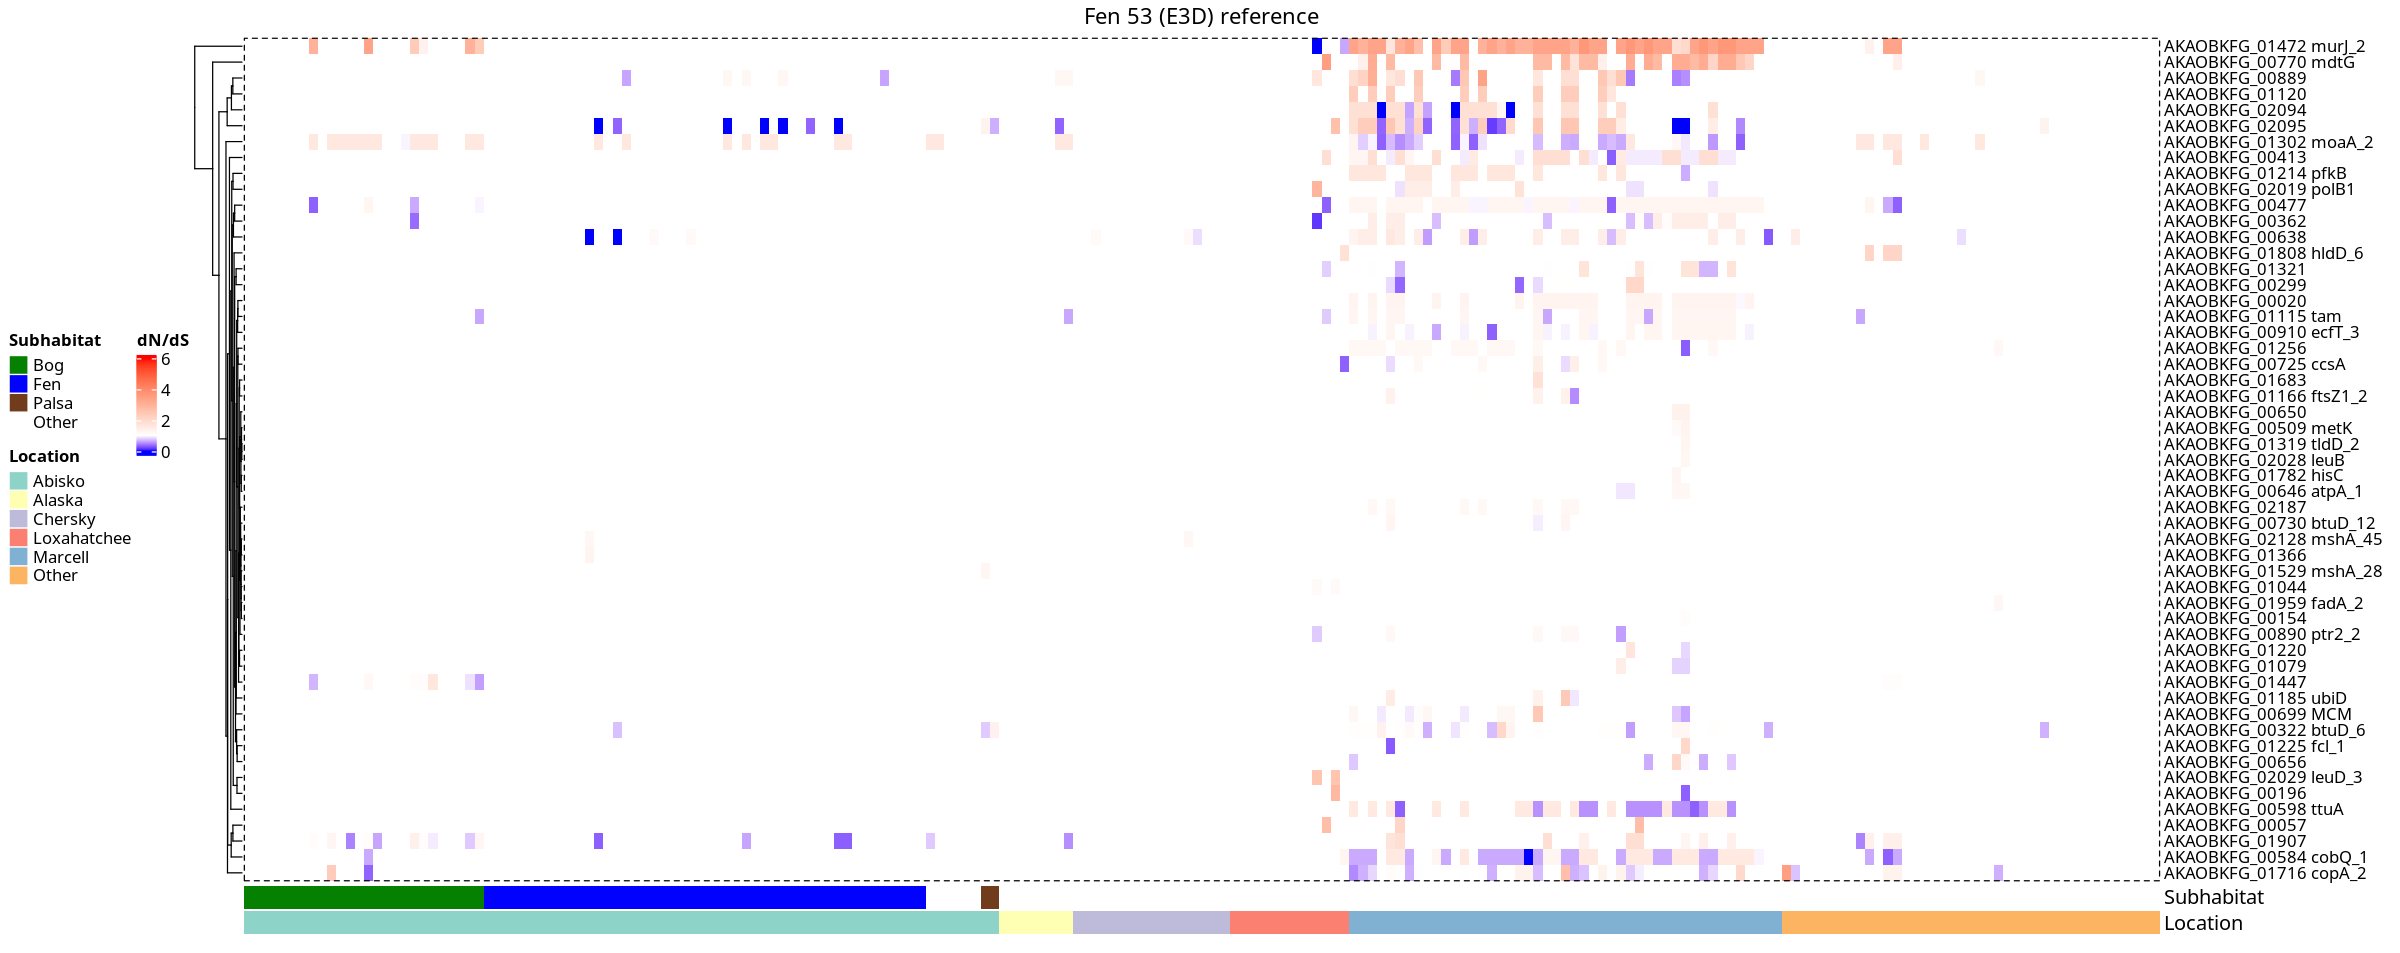

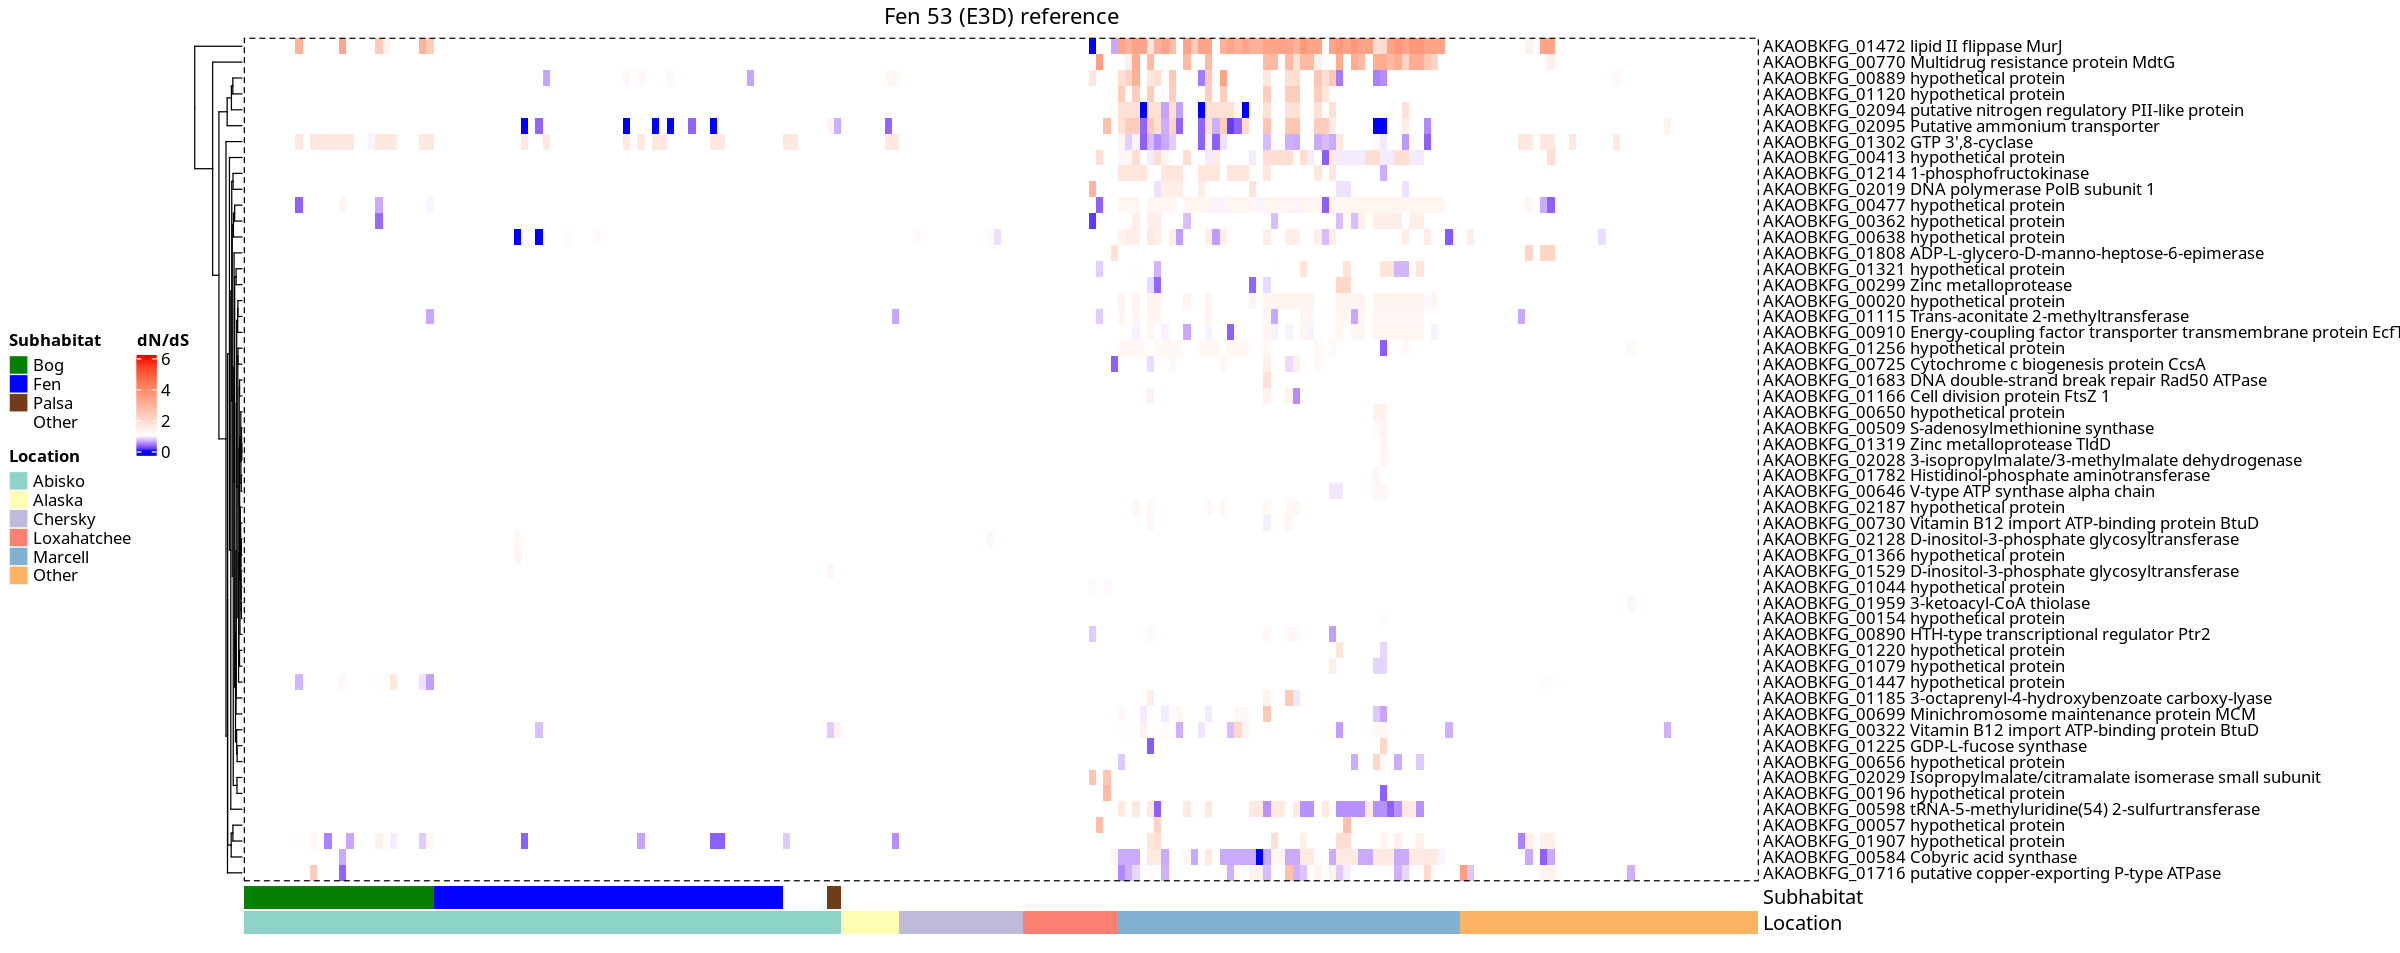

In [9]:
# full process dor e3d

prok_e3d <- read.gff(paste0(main_dir, '09_methanoflorens/references/prokka_e3d/clean_20120600_E3D.gff'))
lor_e3d <- read.gff(paste0(main_dir, '00-lorikeet_call/GCA_003158275.1_20120600_E3D_genomic/GCA_003158275.1_20120600_E3D_genomic.gff'))
e3d_tsv <- fread(paste0(main_dir, '09_methanoflorens/references/prokka_e3d/prokka_e3d.tsv'))

lorikeet_e3d <- lorikeet_funct(lor_e3d)
prokka_e3d <- prok_funct(prok_e3d)

comb_e3d <- merge(lorikeet_e3d, prokka_e3d, by=common_variables, all=FALSE) 

e3d_dnds <- data.frame(do.call('rbind', strsplit(as.character(comb_e3d$dN_dS),',',fixed=TRUE)))
e3d_dnds <- mutate_all(e3d_dnds, function(x) as.numeric(as.character(x)))
e3d_dnds$locus_tag <- comb_e3d$locus_tag
                       
e3d_dnds_filt <- e3d_dnds %>% 
    rowwise %>% 
    filter(sum(c_across(where(is.numeric))) != 208) %>%
    ungroup

e3d_matrix <- split_function(e3d_dnds_filt, e3d_tsv)
e3d_matrix2 <- split_function4(e3d_dnds_filt, e3d_tsv)

# upper_boundary_e3d <- mean(e3d_matrix$mean)+(2*sd(e3d_matrix$mean))  

e3d_low <- subset(e3d_matrix, mean>1)[,1:208]
e3d_all <- e3d_matrix[,1:208]
                       
e3d_low2 <- subset(e3d_matrix2, mean>1)[,1:208]
                       
# h1 <- 0.05*nrow(e3d_all)
# options(repr.plot.width=20, repr.plot.height=h1)
# hma <- heatmap_function(e3d_all, col_fun3,"Fen3 (E2D) reference")
# draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
h1 <- 0.15*nrow(e3d_low)
options(repr.plot.width=20, repr.plot.height=h1)
hma <- heatmap_function(e3d_low, col_fun3, "Fen 53 (E3D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
hma2 <- heatmap_function(e3d_low2, col_fun3, "Fen 53 (E3D) reference")
draw(hma2, heatmap_legend_side = "left", annotation_legend_side = "left")

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


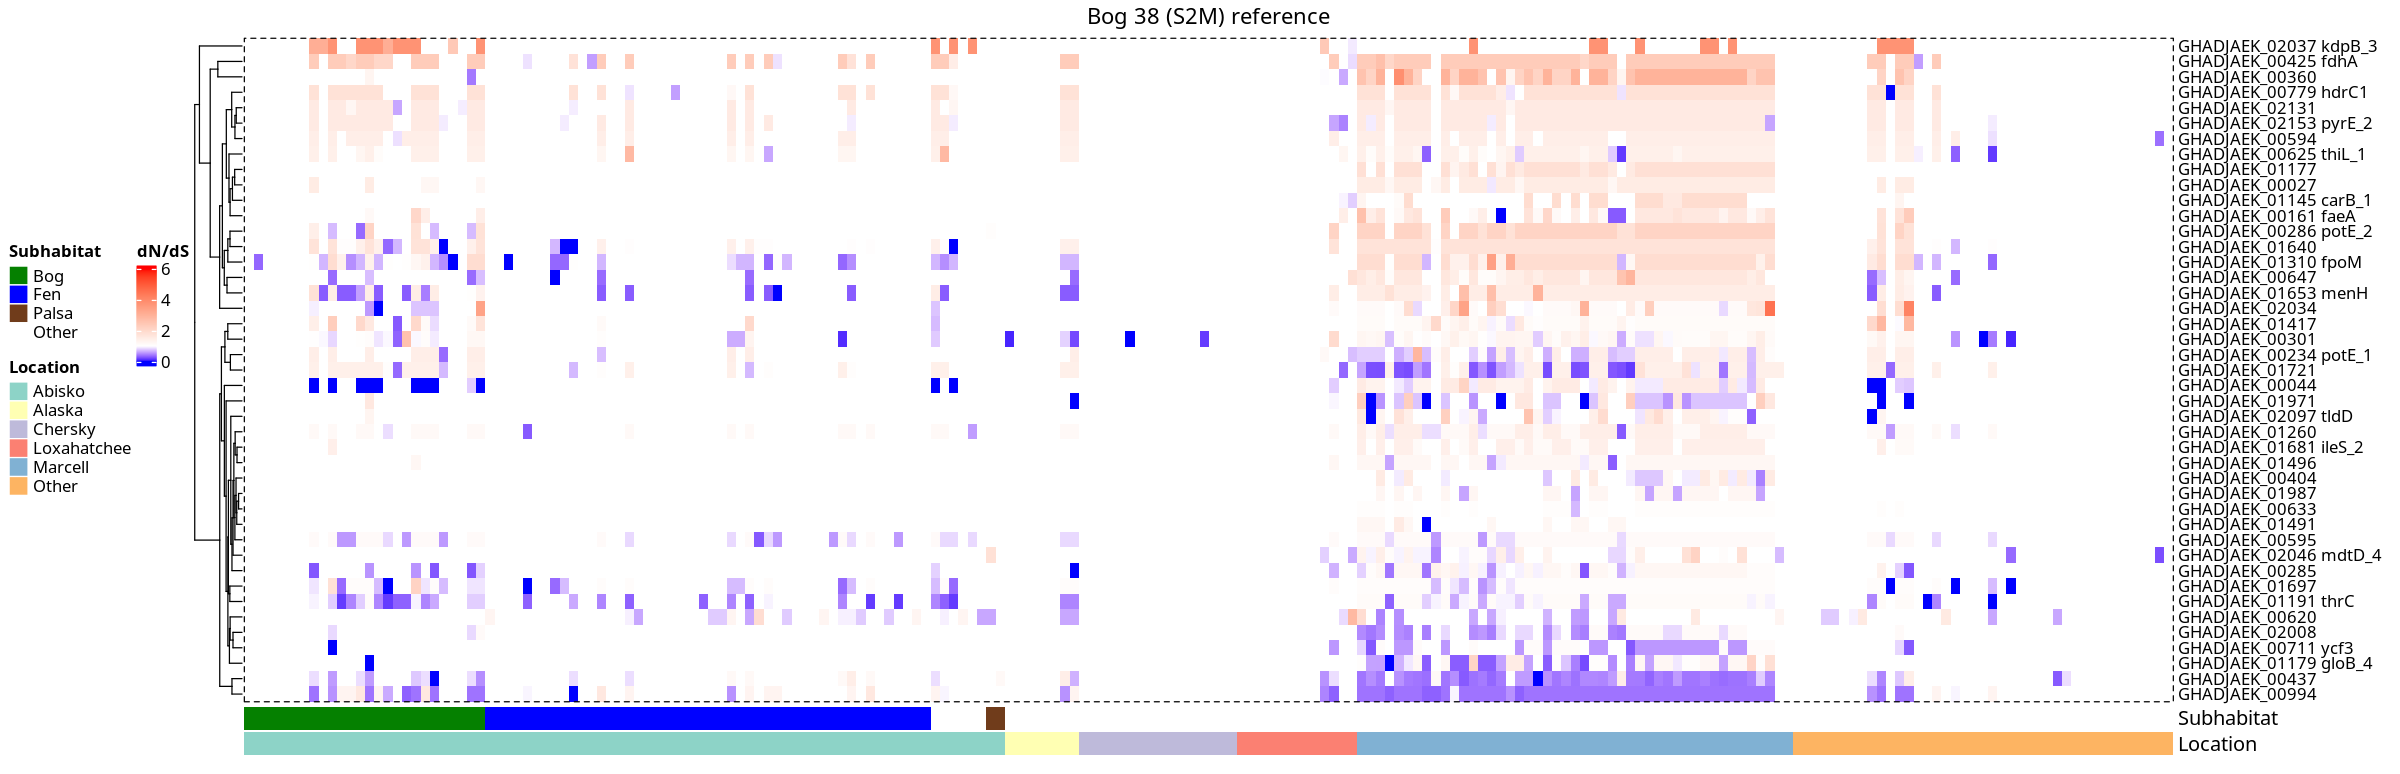

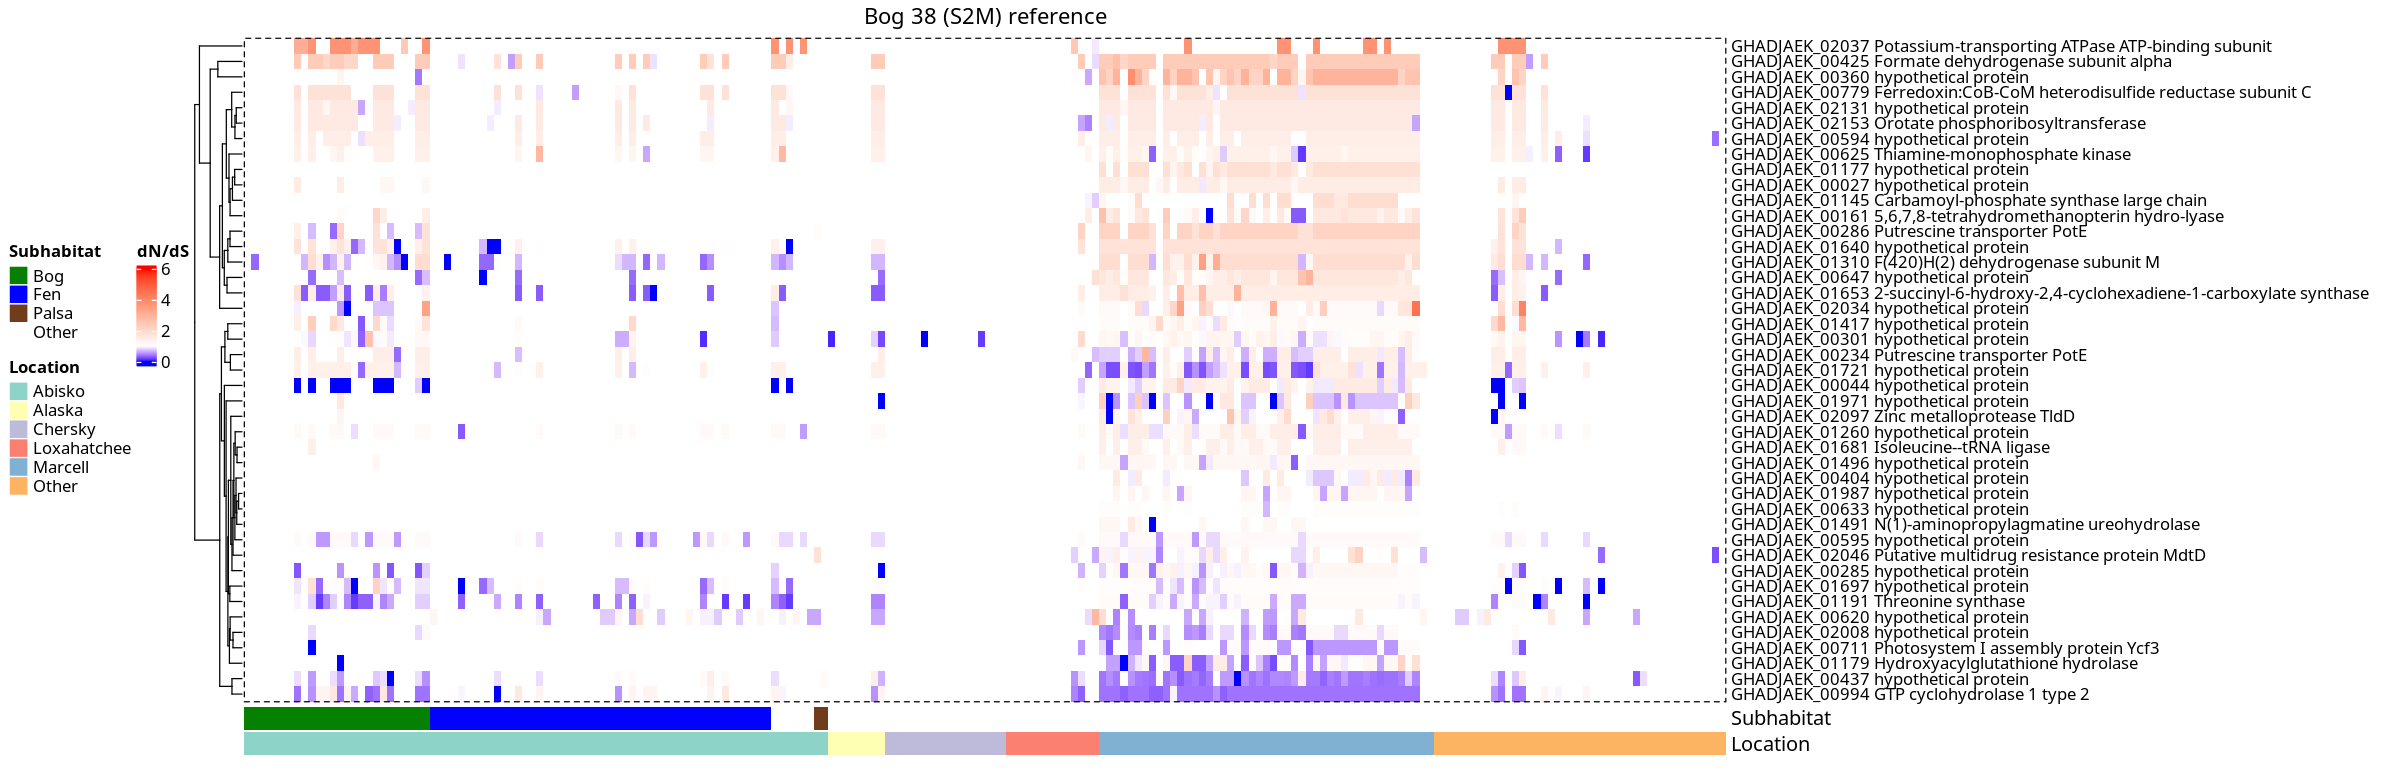

In [10]:
# full process dor s2m

prok_s2m <- read.gff(paste0(main_dir, '09_methanoflorens/references/prokka_s2m/clean_20110800_S2M.gff'))
lor_s2m <- read.gff(paste0(main_dir, '00-lorikeet_call/GCA_003139855.1_20110800_S2M_genomic/GCA_003139855.1_20110800_S2M_genomic.gff'))
s2m_tsv <- fread(paste0(main_dir, '09_methanoflorens/references/prokka_s2m/prokkas2m.tsv'))

lorikeet_s2m <- lorikeet_funct(lor_s2m)
prokka_s2m <- prok_funct(prok_s2m)

comb_s2m <- merge(lorikeet_s2m, prokka_s2m, by=common_variables, all=FALSE) 

s2m_dnds <- data.frame(do.call('rbind', strsplit(as.character(comb_s2m$dN_dS),',',fixed=TRUE)))
s2m_dnds <- mutate_all(s2m_dnds, function(x) as.numeric(as.character(x)))
s2m_dnds$locus_tag <- comb_s2m$locus_tag

s2m_snps <- data.frame(do.call('rbind', strsplit(as.character(comb_s2m$snps),',',fixed=TRUE)))
s2m_snps <- mutate_all(s2m_snps, function(x) as.numeric(as.character(x)))
s2m_snps$locus_tag <- comb_s2m$locus_tag
s2m_snps$length <- comb_s2m$end - comb_s2m$start

s2m_indels <- data.frame(do.call('rbind', strsplit(as.character(comb_s2m$indels),',',fixed=TRUE)))
s2m_indels <- mutate_all(s2m_indels, function(x) as.numeric(as.character(x)))
s2m_indels$locus_tag <- comb_s2m$locus_tag
s2m_indels$length <- comb_s2m$end - comb_s2m$start

                       
s2m_dnds_filt <- s2m_dnds %>% 
    rowwise %>% 
    filter(sum(c_across(where(is.numeric))) != 208) %>%
    ungroup

s2m_matrix <- split_function(s2m_dnds_filt, s2m_tsv)
s2m_matrix2 <- split_function4(s2m_dnds_filt, s2m_tsv)
# upper_boundary_s2m <- mean(s2m_matrix$mean)+(2*sd(s2m_matrix$mean))  

s2m_low <- subset(s2m_matrix, pos>=10)[,1:208]
s2m_all <- s2m_matrix[,1:208]
                       
s2m_low2 <- subset(s2m_matrix2, pos>=10)[,1:208]
s2m_all2 <- s2m_matrix2[,1:208]
                       
# h1 <- 0.05*nrow(s2m_all)
# options(repr.plot.width=20, repr.plot.height=h1)
# hma <- heatmap_function(s2m_all, col_fun3,"Fen3 (E2D) reference")
# draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
h1 <- 0.15*nrow(s2m_low)
options(repr.plot.width=20, repr.plot.height=h1)
hma <- heatmap_function(s2m_low, col_fun3, "Bog 38 (S2M) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
hma2 <- heatmap_function(s2m_low2, col_fun3, "Bog 38 (S2M) reference")
draw(hma2, heatmap_legend_side = "left", annotation_legend_side = "left")

In [11]:
#functions for mcr

heatmap_function2 <- function(df, colours,title, name="dN/dS", column_order=order(metadata$order_col), show_row_names=FALSE, row_title_rot=0){
    plot <- Heatmap(df, col=colours,
                name = name, #title of legend
                row_names_gp = gpar(fontsize = 10),
                show_column_names = FALSE,
                show_row_names = show_row_names,
                # column_names_gp = gpar(fontsize = 6),
                row_names_max_width = unit(15, "cm"),
                border_gp = gpar(col = "black", lty = 2),
                row_title={{title}}, 
                row_title_rot=row_title_rot, 
                cluster_rows = FALSE,
                cluster_columns = FALSE,
                na_col=NULL,
                column_order=column_order
               )
    return(plot)
    }

heatmap_function3 <- function(df, colours, title, name="dN/dS", column_order=order(metadata$order_col), show_row_names=FALSE, row_title_rot=0){
    plot <- Heatmap(df, col=colours,
                    name = name, #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    show_column_names = FALSE,
                    show_row_names = show_row_names,
                    # column_names_gp = gpar(fontsize = 6),
                    bottom_annotation = c(subhab,location),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    row_title={{title}}, , 
                    row_title_rot=row_title_rot,
                    cluster_rows = FALSE,cluster_columns = FALSE,
                    na_col=NULL,
                    column_order=column_order
               )
    return(plot)
    }

In [14]:
# MCR 

# t1 <- split_function(e2d_dnds, e2d_tsv)
# t2 <- split_function(e3d_dnds, e3d_tsv)
# t3 <- split_function(s2m_dnds, s2m_tsv)

t1 <- e2d_matrix2
t2 <- e3d_matrix2
t3 <- s2m_matrix2

mcr1 <- subset(t1, (rownames(t1) %like% "methano"|
                  rownames(t1) %like% "erredoxin"|
                  rownames(t1) %like% "ethyl-coenzyme"|
                  rownames(t1) %like% "heterodisulfide reductase"|
                  rownames(t1) %like% "F420"|
                  rownames(t1) %like% "ormate"|
                  rownames(t1) %like% "Methyl"|
                  rownames(t1) %like% "Methan"|
                  rownames(t1) %like% "methylen"))
mcr2 <- subset(t2, (rownames(t2) %like% "methano"|
                  rownames(t2) %like% "erredoxin"|
                  rownames(t2) %like% "ethyl-coenzyme"|
                  rownames(t2) %like% "heterodisulfide reductase"|
                  rownames(t2) %like% "F420"|
                  rownames(t2) %like% "ormate"|
                  rownames(t2) %like% "Methyl"|
                  rownames(t2) %like% "Methan"|
                  rownames(t2) %like% "methylen"))
mcr3 <- subset(t3, (rownames(t3) %like% "methano"|
                  rownames(t3) %like% "erredoxin"|
                  rownames(t3) %like% "ethyl-coenzyme"|
                  rownames(t3) %like% "heterodisulfide reductase"|
                  rownames(t3) %like% "F420"|
                  rownames(t3) %like% "ormate"|
                  rownames(t3) %like% "Methyl"|
                  rownames(t3) %like% "Methan"|
                  rownames(t3) %like% "methylen"))


hma1 <- heatmap_function2(mcr1[, 1:208], col_fun3, "Fen 3", show_row_names=T, row_title_rot=90)
hma2 <- heatmap_function3(mcr2[, 1:208], col_fun3,"Fen 53", show_row_names=T, row_title_rot=90)
hma3 <- heatmap_function2(mcr3[, 1:208], col_fun3, "Bog 38", show_row_names=T, row_title_rot=90)


options(repr.plot.width=20, repr.plot.height=4)

# sexy_list <- hma1%v%hma2%v%hma3
methane_list <- hma3 %v% hma1 %v% hma2
png(paste0(main_dir, "methanogenesis_dnds.svg"),width=18,height=13)
draw(methane_list)
dev.off()


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“Heatmap/annotation names are duplicated: dN/dS”
Warning message:
“Heatmap/annotation names are duplicated: dN/dS, dN/dS”


png 
  2

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


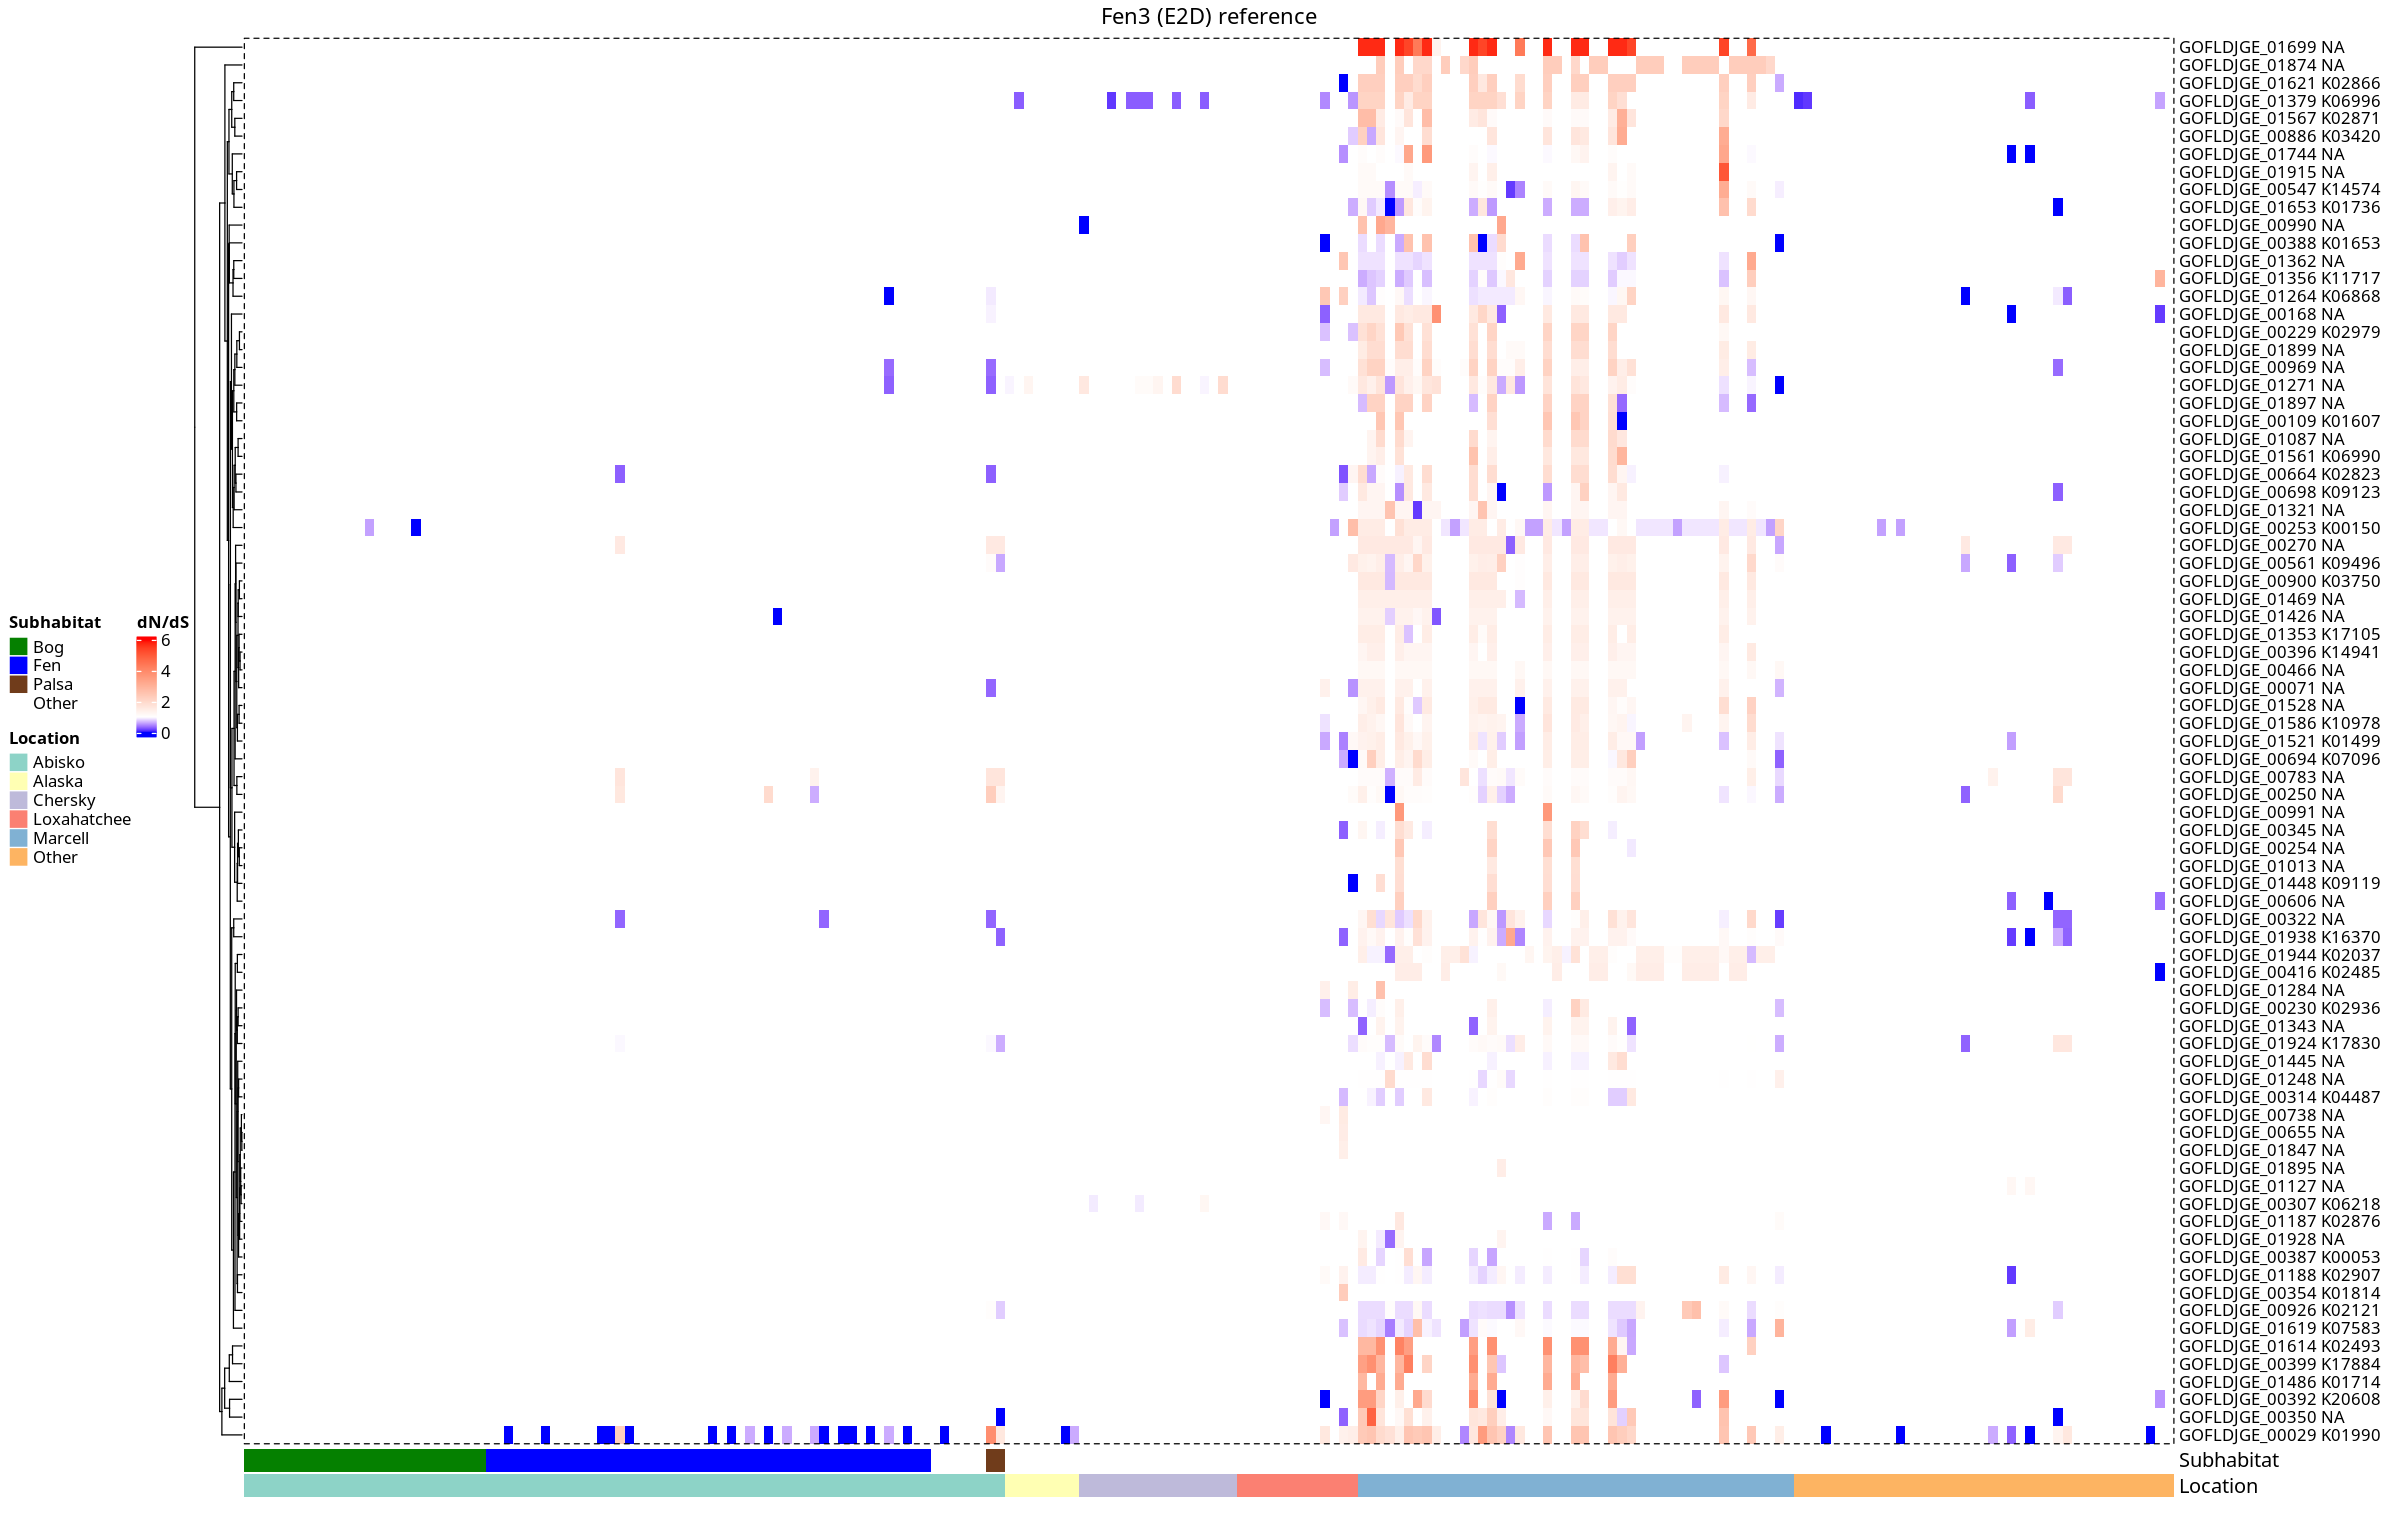

Warning message:
“The input is a data frame, convert it to a matrix.”


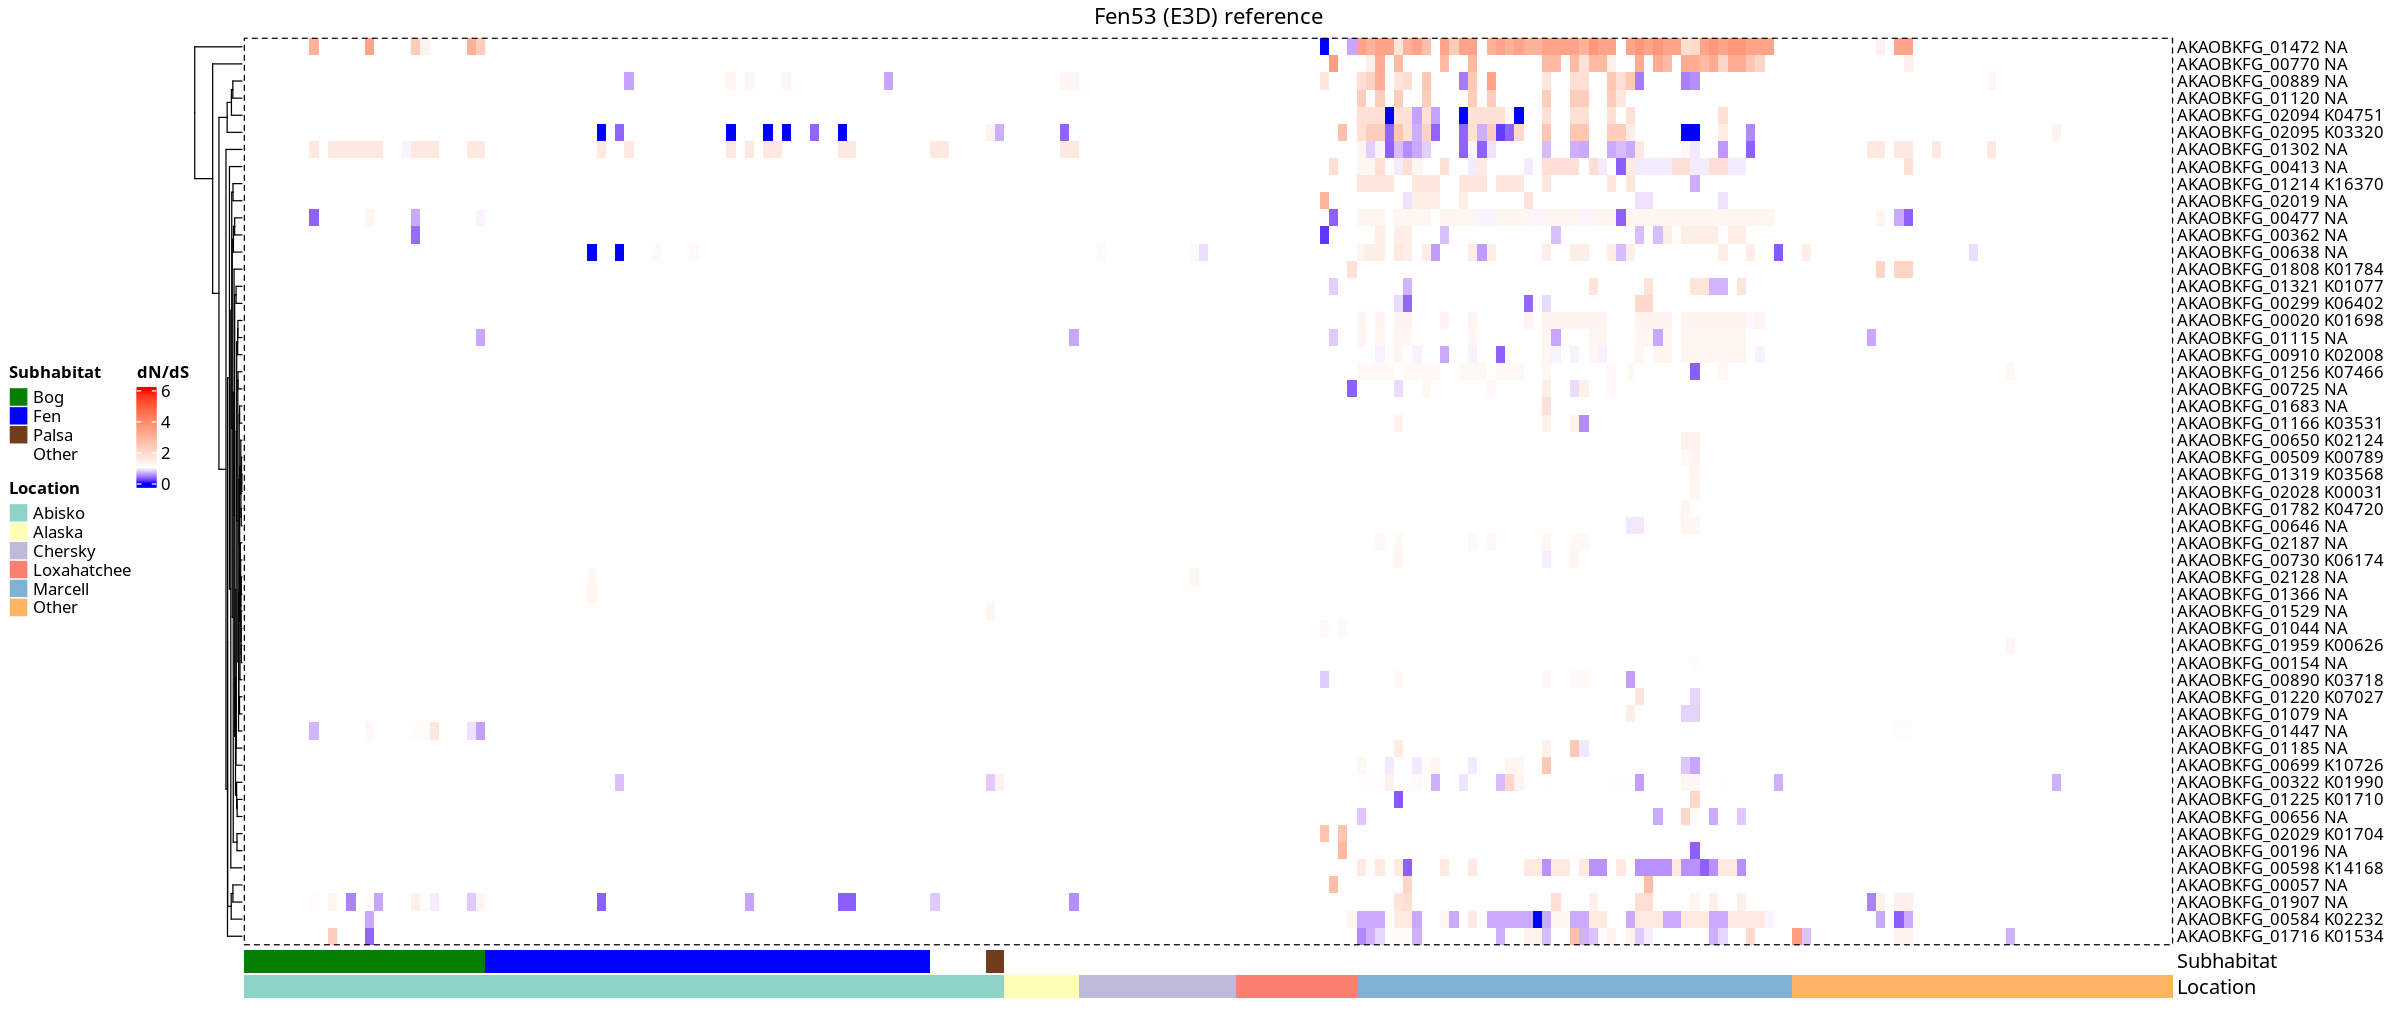

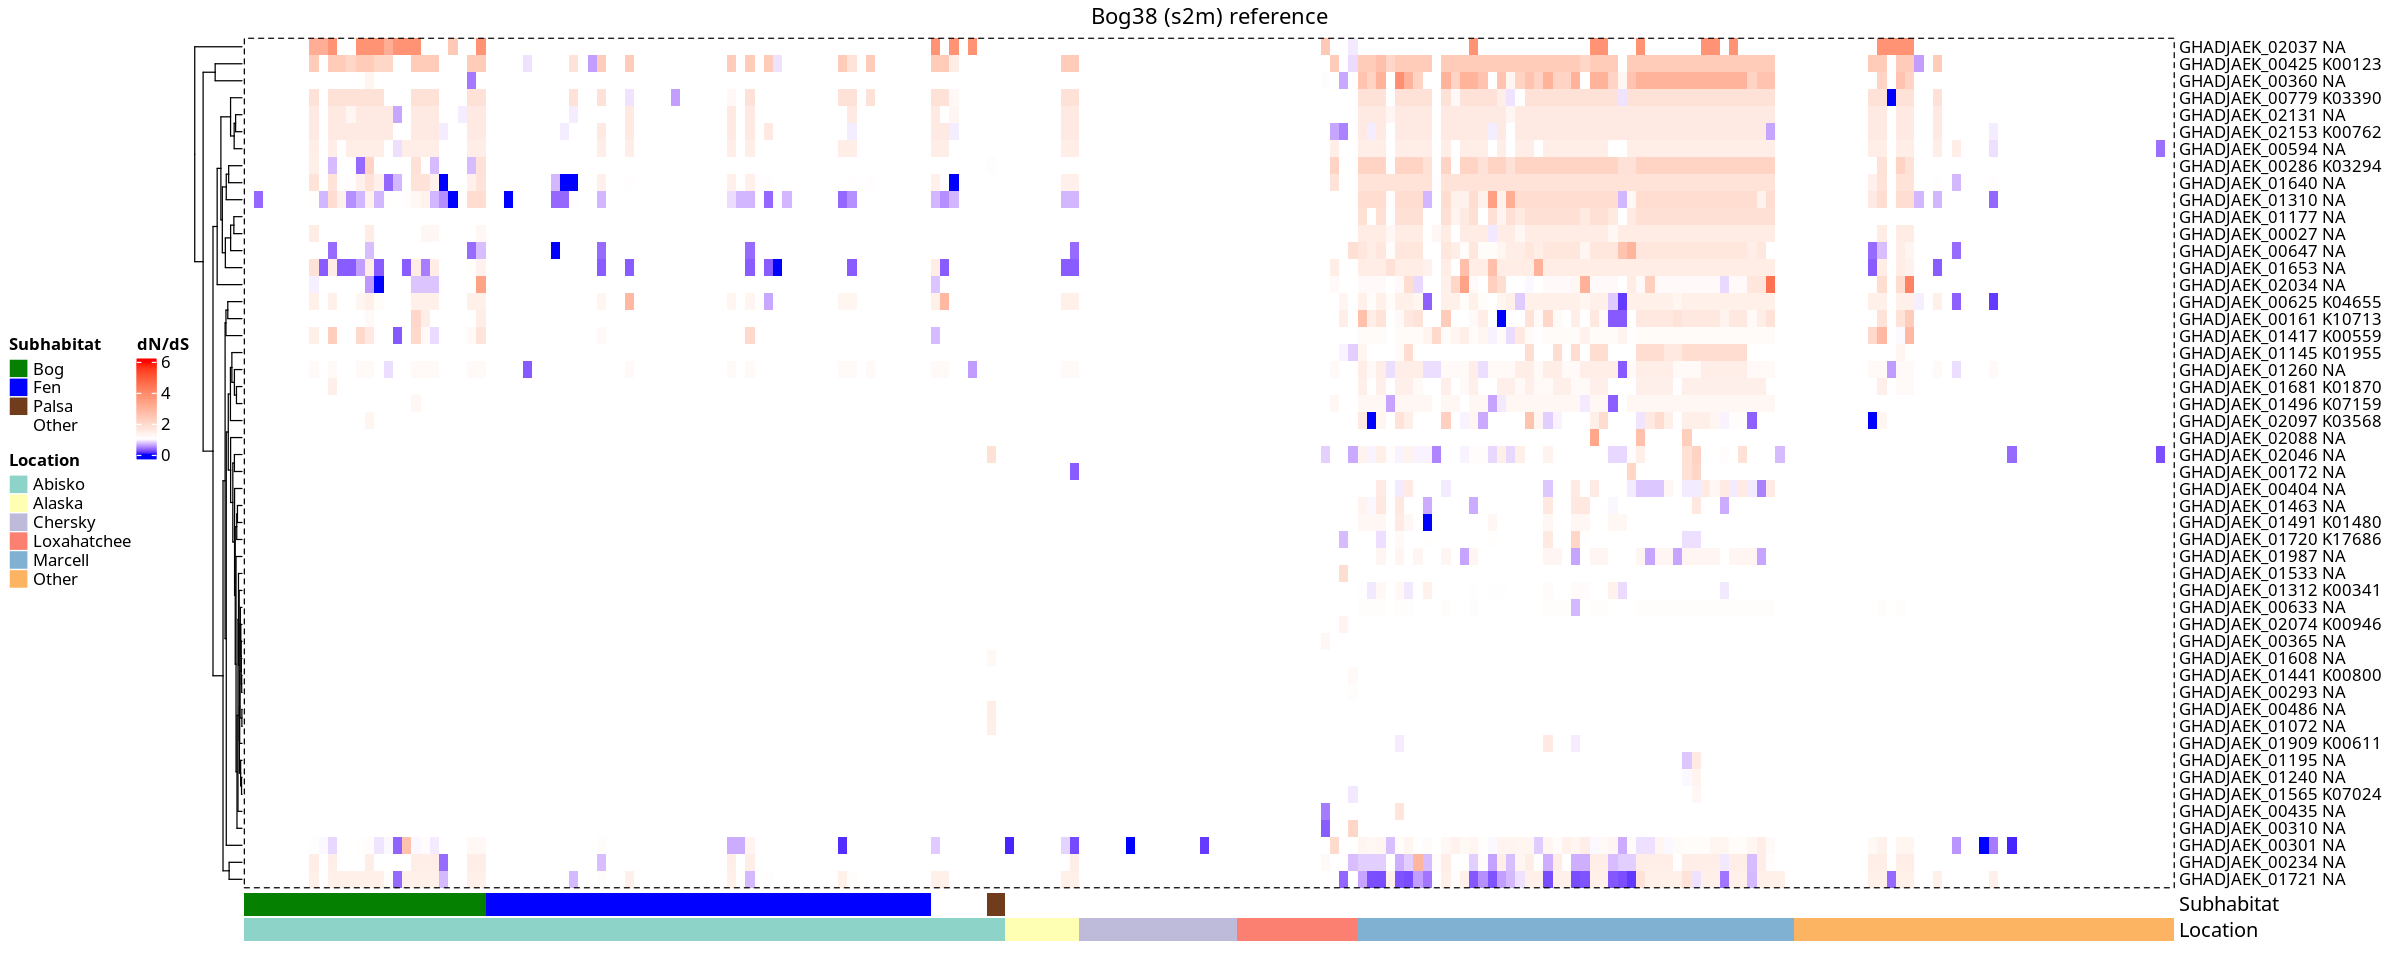

In [14]:
# trying to get KOs plotted -- should try with pfams

ko_e2d <- merge(e2d_dnds_filt, subset(ko5, genome=="fen3"), by="locus_tag", all.x=TRUE) 
ko_e3d <- merge(e3d_dnds_filt, subset(ko5, genome=="fen53"), by="locus_tag", all.x=TRUE) 
ko_s2m <- merge(s2m_dnds_filt, subset(ko5, genome=="bog38"), by="locus_tag", all.x=TRUE) 


split_function2 <- function(dnds, tsv){ 
#     colnames(dnds) <- c(1:208,"locus_tag")
    dnds3 <- merge(dnds, tsv, by="locus_tag", all.x=TRUE)

    dnds3$gene_loc <- paste(dnds3$locus_tag, dnds3$ko)
    dnds4 <- dnds3 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    dnds5 <- dnds4[,2:209]

    dnds5$mean <- apply(dnds5, 1, mean, na.rm=TRUE)
    dnds5$min <- do.call(pmin, dnds5)
    dnds5$max <- do.call(pmax, dnds5)

    
    return(dnds5)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

e2d_matrix <- split_function2(ko_e2d, e2d_tsv)
e2d_low <- subset(e2d_matrix, mean>1)

h <- 0.16*nrow(e2d_low)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(e2d_low[,1:208], col_fun3,"Fen3 (E2D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e3d_matrix <- split_function2(ko_e3d, e3d_tsv)
e3d_low <- subset(e3d_matrix, mean>1)

h <- 0.16*nrow(e3d_low)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(e3d_low[,1:208], col_fun3,"Fen53 (E3D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
s2m_matrix <- split_function2(ko_s2m, s2m_tsv)
s2m_low <- subset(s2m_matrix, mean>1)

h <- 0.16*nrow(s2m_low)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(s2m_low[,1:208], col_fun3,"Bog38 (s2m) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“Heatmap/annotation names are duplicated: dN/dS”
Warning message:
“Heatmap/annotation names are duplicated: dN/dS, dN/dS”


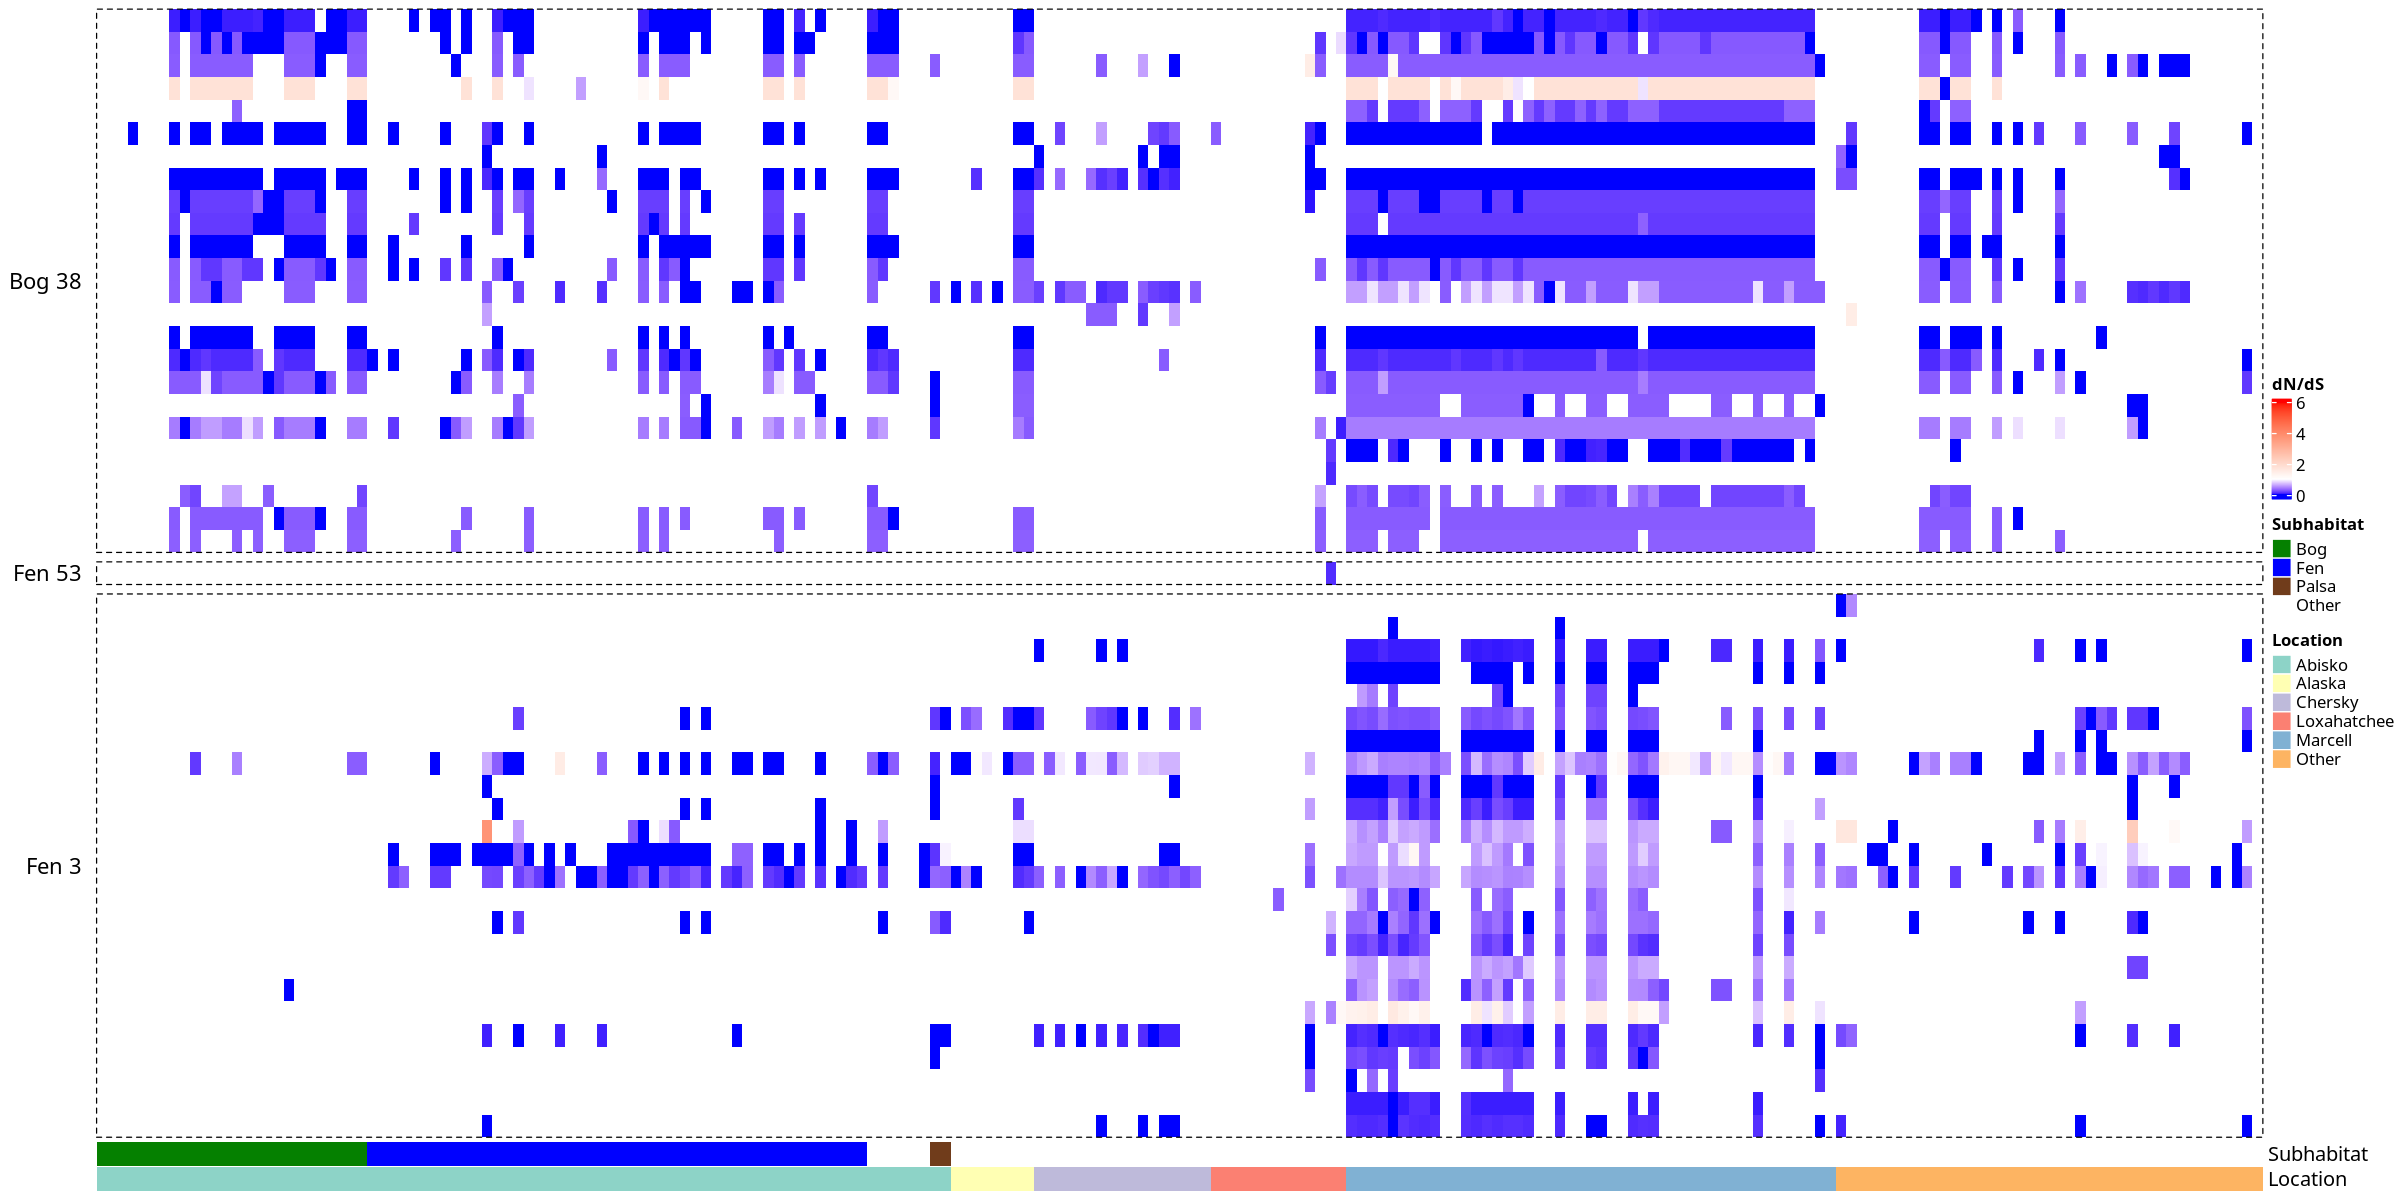

In [16]:
# all of the hydrogenotrophic genes from kegg 

meth_genes_kegg <- fread(paste0(main_dir, '09_methanoflorens/hydrogenotrophic_methanogenesis_kegg.txt'))

split_function5 <- function(dnds, tsv){ 
#     colnames(dnds) <- c(1:208,"locus_tag")
    dnds3 <- merge(dnds, tsv, by="locus_tag", all.x=TRUE)
    return(dnds3)
}

t1 <- split_function5(ko_e2d, e2d_tsv)
t2 <- split_function5(ko_e3d, e3d_tsv)
t3 <- split_function5(ko_s2m, s2m_tsv)

ripper_function <- function(df, filter_by){
    #filter
    df2 <- subset(df, ko %in% filter_by)
    #rownames 
    df2$gene_loc <- paste(df2$locus_tag, df2$gene)
    df3 <- df2 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    #remove columns
    df4 <- df3[,2:209]
    return(df4)
}

o1 <- ripper_function(t1, meth_genes_kegg$ko)
o2 <- ripper_function(t2, meth_genes_kegg$ko)
o3 <- ripper_function(t3, meth_genes_kegg$ko)


hma1 <- heatmap_function3(o1, col_fun3, "Fen 3")
hma2 <- heatmap_function2(o2, col_fun3,"Fen 53")
hma3 <- heatmap_function2(o3, col_fun3, "Bog 38")

options(repr.plot.width=20, repr.plot.height=10)

sexy_list <- hma3%v%hma2%v%hma1

draw(sexy_list)

In [17]:

split_function3 <- function(dnds, tsv){ 
    dnds3 <- merge(dnds, tsv, by="locus_tag", all.x=FALSE)
    dnds3$mean <- apply(dnds3[,2:209], 1, mean, na.rm=TRUE)

    return(dnds3)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

e2d_matrix <- split_function3(ko_e2d, e2d_tsv)
e2d_low <- subset(e2d_matrix, mean>1)
e2d_subset <-  e2d_low[complete.cases(e2d_low), ] 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e3d_matrix <- split_function3(ko_e3d, e3d_tsv)
e3d_low <- subset(e3d_matrix, mean>1)
e3d_subset <-  e3d_low[complete.cases(e3d_low), ] 


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
s2m_matrix <- split_function3(ko_s2m, s2m_tsv)
s2m_low <- subset(s2m_matrix, mean>1)
s2m_subset <-  s2m_low[complete.cases(s2m_low), ] 

test <- merge(e2d_subset[,c(1,210,212,215)], e3d_subset[,c(1,210,212,215)], by=c("ko","gene", "genome", "locus_tag"),
              all=TRUE)
test2 <- merge(test, s2m_subset[,c(1,210,212,215)], by=c("ko","gene", "genome", "locus_tag"), all=TRUE) #must modify
head(test2)

# write.table(test2, "ko_test.tsv", sep='\t')

,ko,gene,genome,locus_tag
,<chr>,<chr>,<chr>,<chr>
1,K00031,leuB,fen53,AKAOBKFG_02028
2,K00053,ilvC,fen3,GOFLDJGE_00387
3,K00123,fdhA,bog38,GHADJAEK_00425
4,K00150,gap,fen3,GOFLDJGE_00253
5,K00341,ndhB,bog38,GHADJAEK_01312
6,K00559,,bog38,GHADJAEK_01417


In [16]:
unique(ko5$genome)

[1] "fen53" "bog38" "fen3"  "e3d"   "e2d"   "s2m"

In [18]:
pfame2d <- fread(header=FALSE, 
              fill=TRUE, 
              "grep -v '^#' /work/microbiome/abisko/eilish/09_methanoflorens/pfam_e2d.csv")

pfame3d <- fread(header=FALSE, 
              fill=TRUE, 
              "grep -v '^#' /work/microbiome/abisko/eilish/09_methanoflorens/pfam_e3d.csv")

pfams2m <- fread(header=FALSE, 
              fill=TRUE, 
              "grep -v '^#' /work/microbiome/abisko/eilish/09_methanoflorens/pfam_s2m.csv")
# pfam$description  <- paste(pfam$V23,pfam$V24,pfam$V25,pfam$V26,pfam$V27,pfam$V28)
# pfam <- pfam[,c(1:22, 29)]

pfam_headers <- c('locus_tag',
                    'accession',
                    'tlen',
                    'query_name',
                    'accession2',
                    'qlen',
                    'E-value',
                    'score',
                    'bias',
                    'number',
                    'of',
                    'c-Evalue',
                    'i-Evalue',
                    'score',
                    'bias',
                    'hmm_from',
                    'hmm_to',
                    'ali_from',
                    'ali_to',
                    'env_from',
                    'env_to',
                    'acc',
                    'description')

pfunct <- function(pfam, filt, pos_min=1.05, neg_max=0.95, required=10){
    colnames(pfam) <- pfam_headers
    pfam$comb <- paste(pfam$locus_tag, pfam$description)
    pfam2 <- pfam[,c(1,23,24)]
    pfam3 <- merge(pfam2, filt, by="locus_tag", all=FALSE) 
    pfam3$mean <- apply(pfam3[,4:211], 1, mean, na.rm=TRUE)
    pfam3$pos <- rowSums(as.matrix(pfam3[,4:211]) >= pos_min)
    pfam3$neg <- rowSums(as.matrix(pfam3[,4:211]) <= neg_max)
    pfam_low <- distinct(subset(pfam3, pos>=required))[,3:211]
    pfam_low <- subset(pfam_low, rownames(pfam_low) != "NA" && rownames(pfam_low) %!like% "NA.")
    pfam_low2 <- pfam_low %>% remove_rownames %>% column_to_rownames(var="comb")
    return(pfam_low2)
#     
}
`%!like%` <- Negate(`%like%`)


In [30]:
s2m_dnds <- as.data.table(s2m_dnds)
# s2m_dnds[, seq(1, 208)]
s2m_dnds$mean_dnds <- rowMeans(s2m_dnds[, seq(1, 208), with=FALSE])
# s2m_dnds
s2m_dnds[`locus_tag` %in% c("GHADJAEK_01150", "GHADJAEK_01151", "GHADJAEK_01152", "GHADJAEK_01153", "GHADJAEK_01154", "GHADJAEK_01155"), ]
s2m_dnds[`locus_tag` %in% c("GHADJAEK_00776", "GHADJAEK_00777", "GHADJAEK_00778", "GHADJAEK_00779", "GHADJAEK_00780", "GHADJAEK_00781"), ]

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X201,X202,X203,X204,X205,X206,X207,X208,locus_tag,mean_dnds
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.1753221,1,0.145794,0.2942967,0.2942967,1.0000000,0.09713663,0.1463195,0.1468427,1,⋯,0.29429666,1,0.29429666,1,1,1,1,1,GHADJAEK_01150,0.6809620
1.0000000,1,1.000000,1.0000000,1.0000000,0.2947858,0.29478580,0.2947858,1.0000000,1,⋯,1.00000000,1,1.00000000,1,1,1,1,1,GHADJAEK_01151,0.9840880
1.0000000,1,1.000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.0000000,1,⋯,1.00000000,1,1.00000000,1,1,1,1,1,GHADJAEK_01152,1.0000000
1.0000000,1,1.000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.0000000,1,⋯,0.00000000,1,0.00000000,1,1,1,1,1,GHADJAEK_01153,0.6394231
1.0000000,1,1.000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.0000000,1,⋯,1.00000000,1,1.00000000,1,1,1,1,1,GHADJAEK_01154,1.0000000
1.0000000,1,1.000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.0000000,1,⋯,0.09624093,1,0.09624093,1,1,1,0,1,GHADJAEK_01155,0.5971610


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X201,X202,X203,X204,X205,X206,X207,X208,locus_tag,mean_dnds
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1,1,1,1,1,1.0000000,1,1,1,⋯,1.7660356,1,1.7660356,1,1,1,1.0000000,1,GHADJAEK_00779,1.2356061
1,1,1,1,1,1,0.3135589,1,1,1,⋯,0.2071897,1,0.1547059,1,1,1,0.1159506,1,GHADJAEK_00780,0.6489691
1,1,1,1,1,1,1.0000000,1,1,1,⋯,1.0000000,1,1.0000000,1,1,1,1.0000000,1,GHADJAEK_00781,0.8004958
1,1,1,1,1,1,0.2946561,1,1,1,⋯,0.2946561,1,0.2946561,1,1,1,1.0000000,1,GHADJAEK_00778,0.6832782
1,1,1,1,1,1,1.0000000,1,1,1,⋯,1.0000000,1,1.0000000,1,1,1,1.0000000,1,GHADJAEK_00776,1.0000000
1,1,1,1,1,1,1.0000000,1,1,1,⋯,0.0000000,1,0.0000000,1,1,1,1.0000000,1,GHADJAEK_00777,0.5432692


In [48]:
options(warn=-1)
low_boundary_e2d <- mean(e2d_matrix2$mean)-(2*sd(e2d_matrix2$mean))  
low_boundary_e3d <- mean(e3d_matrix2$mean)-(2*sd(e3d_matrix2$mean))  
low_boundary_s2m <- mean(s2m_matrix$mean)-(2*sd(s2m_matrix2$mean))  

e2d_high2 <- subset(e2d_matrix2, mean<low_boundary_e2d)[,1:208]           
e3d_high2 <- subset(e3d_matrix2, mean<low_boundary_e3d)[,1:208]           
s2m_high2 <- subset(s2m_matrix2, mean<low_boundary_s2m)[,1:208]           

e2d_pos <- pfunct(pfame2d, e2d_dnds_filt)
e3d_pos <- pfunct(pfame3d, e3d_dnds_filt)
s2m_pos <- pfunct(pfams2m, s2m_dnds_filt)

# merged_pfam2 <- rbind(e2d_high2,e3d_high2)
merged_pfam2 <- e3d_high2

col_fun3 = colorRamp2(c(0,1,6), c("blue", "white", "red"))

dnds_plot <- function(merged_pfam2, column_title, filepath, include_these=c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), col_fun=col_fun3) {
   rownames(merged_pfam2) <- gsub("GOFLDJGE", "fen3", rownames(merged_pfam2))
   rownames(merged_pfam2) <- gsub("AKAOBKFG", "fen53", rownames(merged_pfam2))
   rownames(merged_pfam2) <- gsub("GHADJAEK", "bog38", rownames(merged_pfam2))

   iron_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "Fe"| 
                     rownames(merged_pfam2) %like% "Iron"|
                     rownames(merged_pfam2) %like% "ferr")

   rib_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "ribosom"| 
               rownames(merged_pfam2) %like% "Ribosom")

   dna_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "DNA"| 
                     rownames(merged_pfam2) %like% "chromoso"|
                     rownames(merged_pfam2) %like% "Chromoso"|
                  rownames(merged_pfam2) %like% "polym"|
                  rownames(merged_pfam2) %like% "terminal"|
                  rownames(merged_pfam2) %like% "nuclease"|
                  rownames(merged_pfam2) %like% "helicase"|
                  rownames(merged_pfam2) %like% "topoisomerase"|
                  rownames(merged_pfam2) %like% "segr")

   trna_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "tRNA")

   reg_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "regulat"|
                              rownames(merged_pfam2) %like% "transcr"|
                              rownames(merged_pfam2) %like% "transl"|
                              rownames(merged_pfam2) %like% "factor")

   port_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "port"|
                     rownames(merged_pfam2) %like% "pump"|
                     rownames(merged_pfam2) %like% "Pump")

   hypo_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "hypo"|
                     rownames(merged_pfam2) %like% "Hypo"|
                     rownames(merged_pfam2) %like% "put")

   meth_sub <- subset(merged_pfam2, (rownames(merged_pfam2) %like% "methano"|
                  rownames(merged_pfam2) %like% "erredoxin"|
                  rownames(merged_pfam2) %like% "ethyl-coenzyme"|
                  rownames(merged_pfam2) %like% "disulfide reductase"|
                  rownames(merged_pfam2) %like% "F420"|
                  rownames(merged_pfam2) %like% "ormate"|
                  rownames(merged_pfam2) %like% "Methyl"|
                  rownames(merged_pfam2) %like% "Methan"|
                  rownames(merged_pfam2) %like% "methylen"))

   hydro_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "hydrogen"|
                     rownames(merged_pfam2) %like% "cytochrome")

   energy_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "ATP synthase"|
                rownames(merged_pfam2) %like% "NAD"|
                rownames(merged_pfam2) %like% "GTP"|
                rownames(merged_pfam2) %like% "pyruvate")
   
   drug_sub <- subset(merged_pfam2, rownames(merged_pfam2) %like% "drug"|
                  rownames(merged_pfam2) %like% "Multi")

   all_names <- c(rownames(iron_sub), rownames(rib_sub), rownames(dna_sub),
                  rownames(trna_sub), rownames(reg_sub), rownames(port_sub), #rownames(hypo_sub),
                  rownames(meth_sub), rownames(drug_sub), rownames(energy_sub),
               #    rownames(chap_sub), 
                  rownames(hydro_sub))

   other <- subset(merged_pfam2, !(rownames(merged_pfam2) %in% all_names))

   hma1 <- heatmap_function2(rib_sub, col_fun, "Ribosomal")
   hma2 <- heatmap_function2(trna_sub, col_fun,"tRNA")
   hma3 <- heatmap_function2(dna_sub, col_fun,"DNA")
   hma4 <- heatmap_function2(reg_sub, col_fun,"Regulatory")
   hma5 <- heatmap_function2(iron_sub, col_fun,"Iron")
   hma6 <- heatmap_function2(port_sub, col_fun,"Transport")
   hma7 <- heatmap_function2(meth_sub, col_fun,"Methanogen.", show_row_names=F)
   # hma9 <- heatmap_function2(chap_sub, col_fun3,"chap")
   hma8 <- heatmap_function2(hydro_sub, col_fun,"Hydrogeno.")
   hma9 <- heatmap_function2(energy_sub, col_fun,"Energy")
   hma10 <- heatmap_function2(drug_sub, col_fun,"Drug resist.")
   hma11 <- heatmap_function3(other, col_fun, "Other")
   heatmaps <- c(hma1, hma2, hma3, hma4, hma5, hma6, hma7, hma8, hma9, hma10, hma11)

   # options(repr.plot.width=20, repr.plot.height=12)

   # sexy_list <- hma2%v%hma3%v%hma4%v%hma5%v%hma6%v%hma7%v%hma9%v%hma10%v%hma11%v%hma8
   # purified <- hma2%v%hma3%v%hma4%v%hma6%v%hma11%v%hma8
   purified <- heatmaps[[include_these[[1]]]]
   for (x in include_these[2:length(include_these)]) {
      # print(x)
      purified <- purified %v% heatmaps[[x]]
   }
   # purified <- do.call(`%v%`, lapply(include_these, function(x) {heatmaps[x]}))

   svg(filepath,width=8,height=10)
   # hma5
   draw(purified, column_title=column_title)
   dev.off()
}

col_fun38 = colorRamp2(c(0,1,4), c("blue", "white", "red"))
dnds_plot(s2m_high2, "GCA_003139855.1 (Bog38) Purifying Selection", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/bog38_slight_neg_0.7.2.svg" 
   , include_these=c(2, 3, 4, 7, 11), col_fun38)
dnds_plot(s2m_pos, "GCA_003139855.1 (Bog38) Positive Selection", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/bog38_slight_pos_0.7.2.svg"
   , include_these=c(2, 6, 7, 8, 9, 10, 11), col_fun38)

col_fun3 = colorRamp2(c(0,1,6), c("blue", "white", "red"))
dnds_plot(e2d_high2, "GCA_003162175.1 (Fen3) Purifying Selection", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen3_slight_neg_0.7.2.svg"
   , include_these=c(1, 2, 3, 4, 5, 6, 7, 9, 11))
dnds_plot(e2d_pos, "GCA_003162175.1 (Fen3) Positive Selection", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen3_slight_pos_0.7.2.svg"
   , include_these=c(1, 2, 3, 4, 5, 6, 7, 8, 9, 11))

col_fun53 = colorRamp2(c(0,1,4), c("blue", "white", "red"))
dnds_plot(e3d_high2, "GCA_003158275.1 (Fen53) Purifying Selection", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen53_slight_neg_0.7.2.svg"
   , include_these=c(2, 6, 7, 8, 9, 11), col_fun53)
dnds_plot(e3d_pos, "GCA_003158275.1 (Fen53) Positive Selection", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen53_slight_pos_0.7.2.svg"
   , include_these=c(2, 4, 6, 7, 8, 9, 10, 11), col_fun53)




png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [59]:
svg(paste0(main_dir, "test.svg"))
draw(heatmap_function2(subset(e2d_pos, rowMeans(e2d_pos) > 1.05), col_fun3, "Ribosomal", show_row_names=T))
dev.off()

png 
  2

In [26]:
options(warn=-1)
dnds_dist_plot <- function(comb, dnds, tsv, column_title, filepath) {
    snps <- data.frame(do.call('rbind', strsplit(as.character(comb$snps),',',fixed=TRUE)))
    snps <- mutate_all(snps, function(x) as.numeric(as.character(x)))
    snps$locus_tag <- comb$locus_tag
    snps$length <- comb$end - comb$start

    snps_filt <- snps %>% 
        rowwise %>% 
        filter(sum(c_across(where(is.numeric))) != 208) %>%
        ungroup

    snps_matrix <- split_function(snps_filt, tsv)
    snps_matrix2 <- split_function4(snps[,1:209], tsv)
    
    matrix3 <- split_function4(dnds, tsv)

    ribo_dnds <- subset(matrix3[,1:208] , rownames(matrix3[,1:208] ) %like% "ribosomal protein"| 
                rownames(matrix3[,1:208] ) %like% "Ribosomal protein")

    ribo_snps <- as.data.table(subset(snps_matrix2[,1:208] , rownames(snps_matrix2[,1:208] ) %like% "ribosomal protein"| 
                rownames(snps_matrix2[,1:208] ) %like% "Ribosomal protein"))
    # print(snps_matrix2)

    col_fun5 = colorRamp2(c(0, 1, max(ribo_dnds)), c("blue", "white", "red"))
    ribo_dnds <- heatmap_function2(ribo_dnds, col_fun3, "Ribosomal proteins dN/dS", show_row_names=F, row_title_rot=90)
    col_fun4 = colorRamp2(c(min(ribo_snps), (min(ribo_snps)) / 2, max(ribo_snps)), c("#ffffff", "#7fcdbb", "#db6161"))
    ribo_snps <- heatmap_function3(ribo_snps, col_fun4, "Ribosomal proteins SNVs", "SNVs", show_row_names=F, row_title_rot=90)

    ribo_plot <- ribo_dnds %v% ribo_snps

    svg(filepath,width=8,height=8)
    draw(ribo_plot, column_title=column_title, column_title_gp=gpar(fontsize=16))
    dev.off()
}

dnds_dist_plot(comb_s2m, s2m_dnds, s2m_tsv, "GCA_003139855.1 (Bog38) Ribosomal protein variation", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/bog38_ribosomal_0.7.2.svg")
dnds_dist_plot(comb_e2d, e2d_dnds, e2d_tsv, "GCA_003162175.1 (Fen3) Ribosomal protein variation", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen3_ribosomal_0.7.2.svg")
dnds_dist_plot(comb_e3d, e3d_dnds, e3d_tsv, "GCA_003158275.1 (Fen53) Ribosomal protein variation", "/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen53_ribosomal_0.7.2.svg")



png 
  2

png 
  2

png 
  2

In [46]:
options(warn=-1)
ribo_t_test <- function(comb, dnds, tsv, title="GCA_003139855.1 (Bog38)") {

    indels <- data.frame(do.call('rbind', strsplit(as.character(comb$indels),',',fixed=TRUE)))
    indels <- mutate_all(indels, function(x) as.numeric(as.character(x)))
    indels$locus_tag <- comb$locus_tag
    indels$length <- comb$end - comb$start

    snps <- data.frame(do.call('rbind', strsplit(as.character(comb$snps),',',fixed=TRUE)))
    snps <- mutate_all(snps, function(x) as.numeric(as.character(x)))
    snps$locus_tag <- comb$locus_tag
    snps$length <- comb$end - comb$start

    dnds_sums <- rowSums(dnds[, 1:208])
    
    dnds_filt <- dnds[dnds_sums != 208, ]
    matrix <- split_function(dnds_filt, tsv)
    # matrix2 <- split_function4(dnds_filt, tsv) #product and location 

    snps_filt <- snps[dnds_sums != 208, ]

    snps_matrix <- split_function(snps_filt, tsv)
    snps_matrix2 <- split_function4(snps[,1:209], tsv)

    ribo_snps <- as.data.table(subset(snps_matrix2[,1:208] , rownames(snps_matrix2[,1:208] ) %like% "ribosomal protein"| 
                rownames(snps_matrix2[,1:208] ) %like% "Ribosomal protein"))

        
    not_ribo_snps <- as.data.table(subset(snps_matrix2[,1:208] , rownames(snps_matrix2[,1:208] ) %!like% "ribosomal protein"))
    t.test(rowMeans(ribo_snps), rowMeans(not_ribo_snps))

    long <- melt(setDT(dnds_filt), id.vars = "locus_tag", variable.name = "sample", value.name="dnds")
    long$dnds <- as.numeric(long$dnds)
    
    plot_theme <- theme(plot.title=element_text(size=20, face="bold", hjust=0.5), 
                        axis.text=element_text(size=16), axis.title.x=element_text(size=16), 
                        axis.title.y=element_text(size=20))

    low_boundary <- mean(matrix$mean)-(2*sd(matrix$mean))  
    dnds_dist <- ggplot(matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
            labs(y="", x="Mean dN/dS per gene", title=title) +
            theme_few()+scale_x_log10()+
        #     scale_y_log10() + 
            geom_vline(xintercept=mean(matrix$mean), color="blue", linetype="dashed")+
            geom_vline(xintercept=1, color='red', linetype="dashed")+
            geom_vline(xintercept=low_boundary, color='red', linetype="dashed") +
            plot_theme
    
    low_boundary <- max(mean(snps_matrix$mean)-(2*sd(snps_matrix$mean)), 0)
    high_boundary <- mean(snps_matrix$mean)+(2*sd(snps_matrix$mean))
    snvs_dist <- ggplot(snps_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
            labs(y="Genes", x="Mean SNVs per gene") +
        #     scale_y_log10() + 
            theme_few()+
            geom_vline(xintercept=mean(snps_matrix$mean), color="blue", linetype="dashed")+
            geom_vline(xintercept=high_boundary, color='red', linetype="dashed")+
            geom_vline(xintercept=low_boundary, color='red', linetype="dashed") +
            plot_theme
    

    indels_filt <- indels[dnds_sums != 208, ]
    print(nrow(snps_filt))
    print(nrow(indels_filt))

    indels_matrix <- split_function(indels_filt, tsv)
    low_boundary <- max(mean(indels_matrix$mean)-(2*sd(indels_matrix$mean)), 0)
    high_boundary <- mean(indels_matrix$mean)+(2*sd(indels_matrix$mean))
    indels_dist <- ggplot(indels_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
            labs(y="", x="Mean indels per gene") +
        #     scale_y_log10() + 
            theme_few()+
            geom_vline(xintercept=mean(indels_matrix$mean), color="blue", linetype="dashed")+
            geom_vline(xintercept=high_boundary, color='red', linetype="dashed")+
            geom_vline(xintercept=low_boundary, color='red', linetype="dashed") +
            plot_theme

    ggarrange(dnds_dist, snvs_dist, indels_dist, ncol=1)
}

svg("/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/bog38_dnds_distributions.svg",width=8,height=8)
ribo_t_test(comb_s2m, s2m_dnds, s2m_tsv, "GCA_003139855.1 (Bog38)")
dev.off()

svg("/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen3_dnds_distributions.svg",width=8,height=8)
ribo_t_test(comb_e2d, e2d_dnds, e2d_tsv, "GCA_003162175.1 (Fen3)")
dev.off()

svg("/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen53_dnds_distributions.svg",width=8,height=8)
ribo_t_test(comb_e3d, e3d_dnds, e3d_tsv, "GCA_003158275.1 (Fen53)")
dev.off()

[1] 1058
[1] 1058


png 
  2

[1] 1562
[1] 1562


png 
  2

[1] 908
[1] 908


png 
  2

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



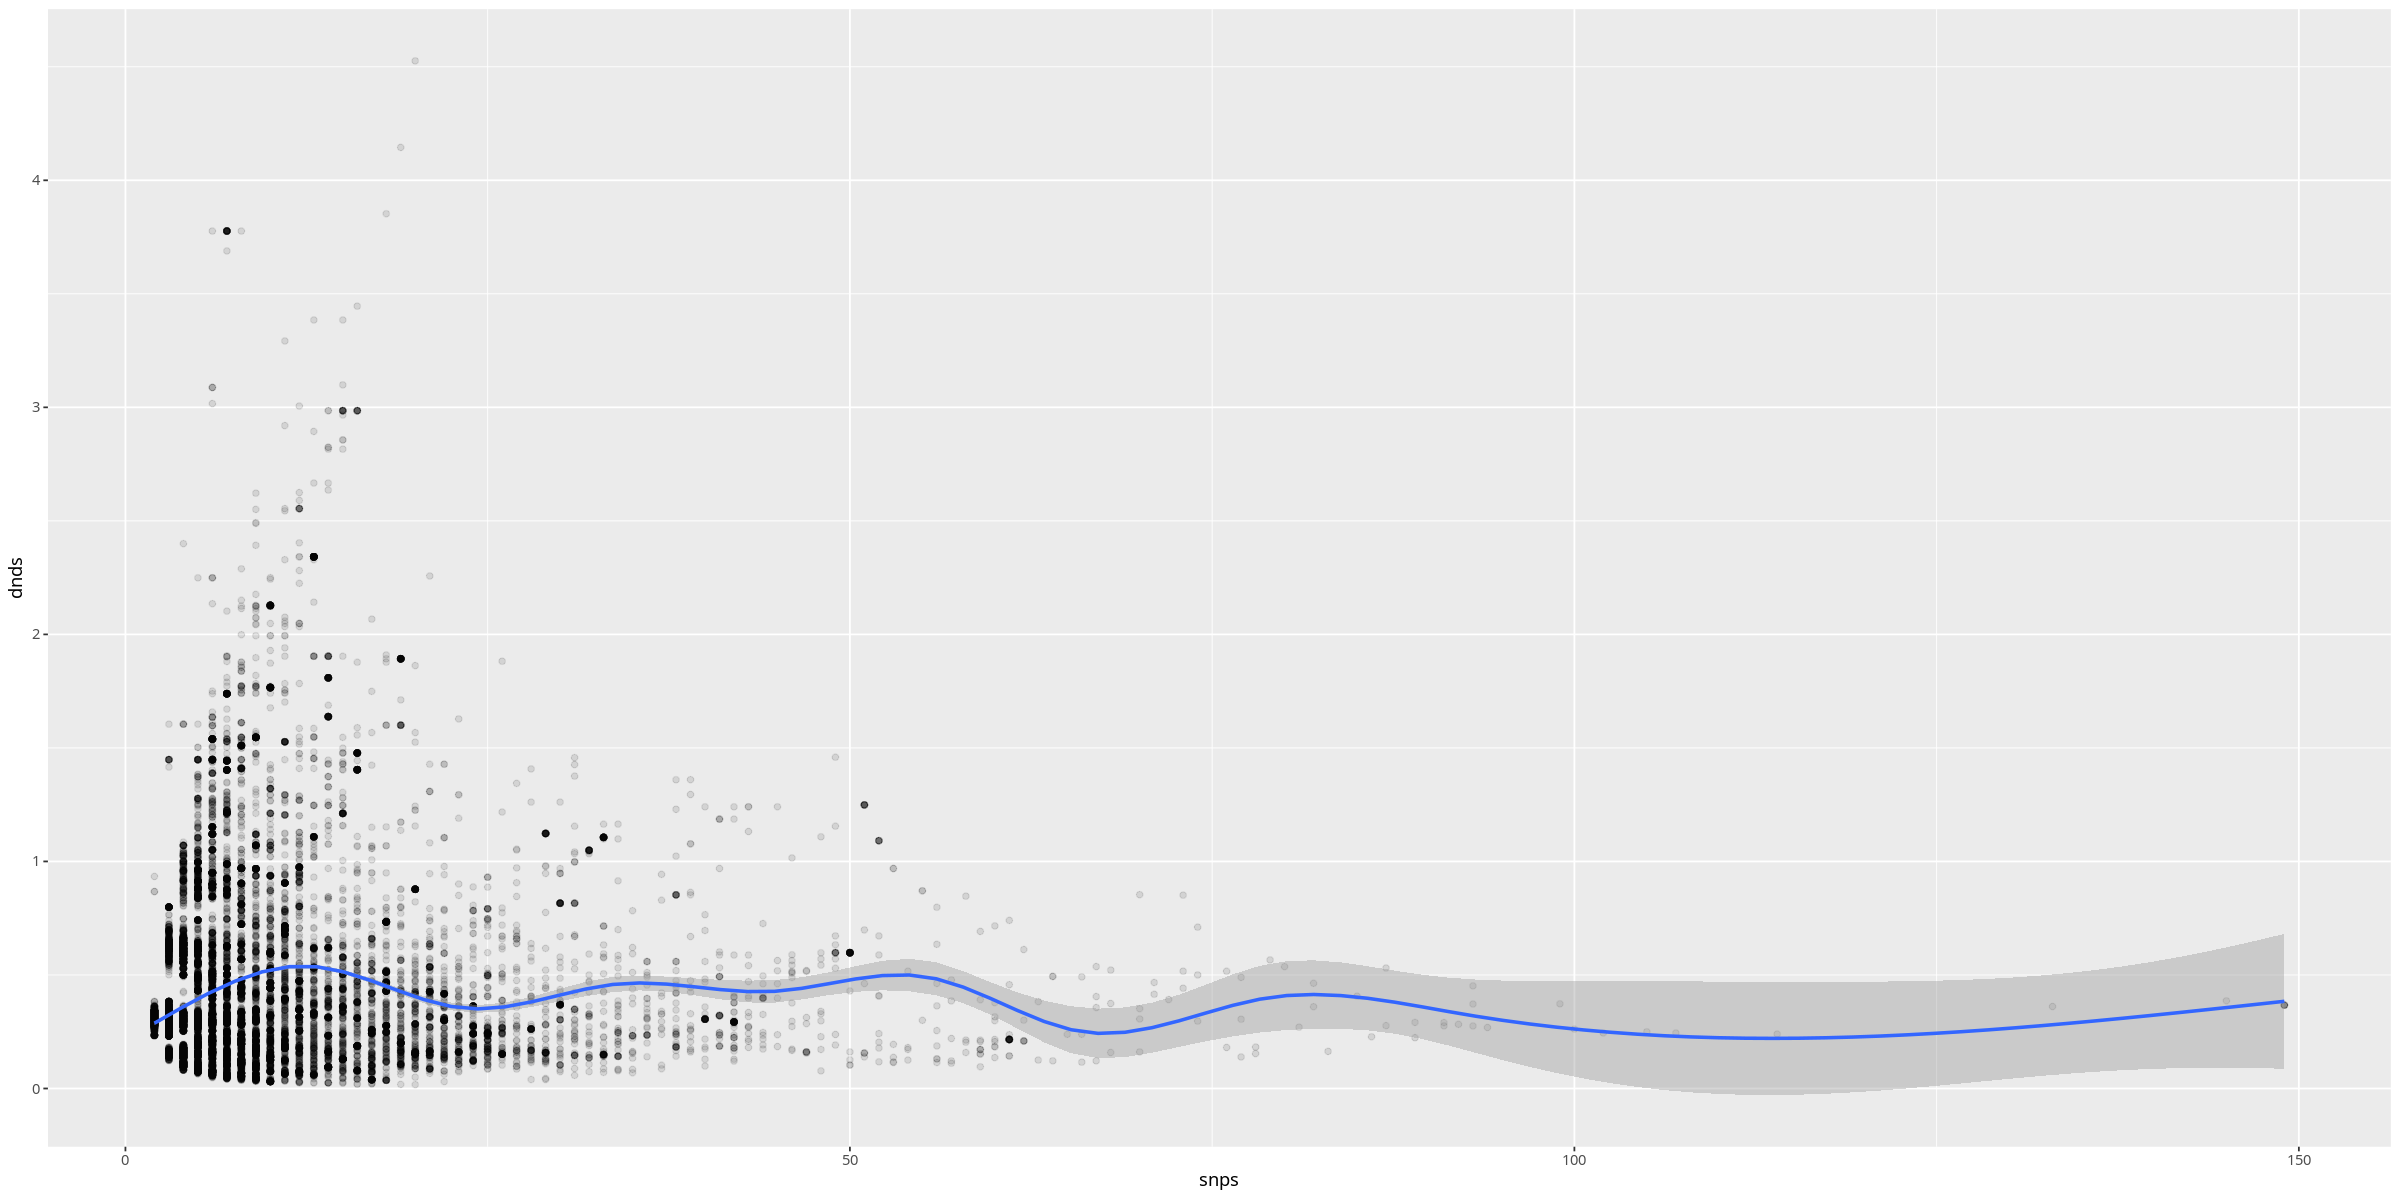

In [71]:
s2m_dnds_long <- as.data.table(melt(setDT(s2m_dnds), id.vars = "locus_tag", variable.name = "sample", value.name="dnds"))
s2m_snps_long <- melt(setDT(s2m_snps), id.vars = c("locus_tag", "length"), variable.name = "sample", value.name="snps")
s2m_snps_and_dnds <- as.data.table(inner_join(s2m_dnds_long, s2m_snps_long, by=c("locus_tag", "sample")))
# s2m_snps_and_dnds
ggplot(data=s2m_snps_and_dnds[dnds!=1 & dnds > 0]) +
    geom_point(aes(y=dnds, x=snps), alpha=0.1) +
    geom_smooth(aes(y=dnds, x=snps))

In [72]:
# s2m_dnds[, seq(1, 208), with=FALSE]
# rowMeans(s2m_dnds[, seq(1, 208), with=FALSE]) != 1
s2m_dnds_long <- as.data.table(melt(setDT(s2m_dnds_filt), id.vars = "locus_tag", variable.name = "sample", value.name="dnds"))
# s2m_dnds_long
sum(rowMeans(s2m_dnds_filt[, seq(1, 208), with=FALSE]) < 1) / nrow(s2m_dnds_filt)
nrow(s2m_dnds_long[dnds == 1]) / nrow(s2m_dnds_long)

[1] 0.952741

[1] 0.7944325

In [ ]:
e2d_long <- melt(setDT(e2d_dnds_filt), id.vars = "locus_tag", variable.name = "sample", value.name="dnds")
e2d_long$dnds <- as.numeric(e2d_long$dnds)

s2m_long <- melt(setDT(s2m_dnds_filt), id.vars = "locus_tag", variable.name = "sample", value.name="dnds")
s2m_long$dnds <- as.numeric(s2m_long$dnds)

e3d_long <- melt(setDT(e3d_dnds_filt), id.vars = "locus_tag", variable.name = "sample", value.name="dnds")
e3d_long$dnds <- as.numeric(e3d_long$dnds)

a <- ggplot(e2d_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
        labs(y="Genes", title="Mean dN/dS per gene") +
        theme_few()+xlab("GCA_003162175.1 (Fen3)")+scale_x_log10()+
        geom_vline(xintercept=mean(e2d_matrix$mean), color="blue", linetype="dashed")+
        geom_vline(xintercept=1, color='red', linetype="dashed")+
        geom_vline(xintercept=low_boundary_e2d, color='red', linetype="dashed") +
        theme(plot.title=element_text(size=32, face="bold", hjust=0.5), axis.text=element_text(size=24), axis.title.x=element_text(size=22), axis.title.y=element_text(size=28))

b <- ggplot(e3d_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
        labs(y="Genes", title="Mean dN/dS per gene") +
        theme_few()+xlab("GCA_003158275.1 (Fen53)")+scale_x_log10()+
        geom_vline(xintercept=mean(e3d_matrix$mean), color="blue", linetype="dashed")+
        geom_vline(xintercept=1, color='red', linetype="dashed")+
        geom_vline(xintercept=low_boundary_e3d, color='red', linetype="dashed") +
        theme(plot.title=element_text(size=32, face="bold", hjust=0.5), axis.text=element_text(size=24), axis.title.x=element_text(size=22), axis.title.y=element_text(size=28))

c <- ggplot(s2m_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
        labs(y="Genes", title="Mean dN/dS per gene") +
        theme_few()+xlab("GCA_003139855.1 (Bog38)")+scale_x_log10()+
        geom_vline(xintercept=mean(s2m_matrix$mean), color="blue", linetype="dashed")+
        geom_vline(xintercept=1, color='red', linetype="dashed")+
        geom_vline(xintercept=low_boundary_s2m, color='red', linetype="dashed") +
        theme(plot.title=element_text(size=32, face="bold", hjust=0.5), axis.text=element_text(size=24), axis.title.x=element_text(size=22), axis.title.y=element_text(size=28))

options(repr.plot.width=8, repr.plot.height=3)
# ggarrange(a,b,c, ncol=3)
title <- "Mean dN/dS per gene"
title_grob <- text_grob(title, size=38, face="bold")
plot_title <- as_ggplot(title_grob) + theme(plot.margin = margin(0,0,0,0, "cm"))

svg("/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen3_dnds_distributions.svg",width=8,height=8)
a
dev.off()

svg("/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/fen53_dnds_distributions.svg",width=8,height=8)
b
dev.off()


svg("/home/n10853499/00-jupyter/02-lorikeet_testing/00-eilish_plots/bog38_dnds_distributions.svg",width=8,height=8)
c
dev.off()


# a <- ggplot(e2d_long, aes(dnds))+geom_histogram(bins=35)+
#         theme_few()+xlab("E2D dnds per gene")+scale_y_log10()
# b <- ggplot(e3d_long, aes(dnds))+geom_histogram(bins=35)+
#         theme_few()+xlab("E3D dnds per gene")+scale_y_log10()
# c <- ggplot(s2m_long, aes(dnds))+geom_histogram(bins=35)+
#         theme_few()+xlab("S2M dnds per gene")+scale_y_log10()

# options(repr.plot.width=8, repr.plot.height=3)
# ggarrange(a,b,c, ncol=3)

png 
  2

png 
  2

png 
  2

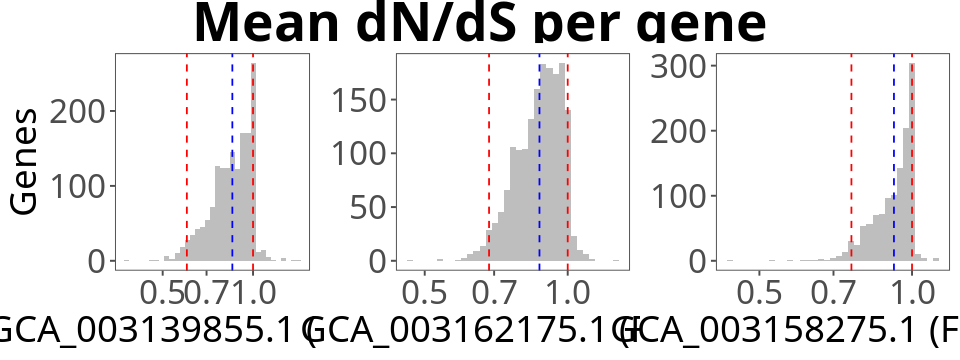

In [261]:
ggarrange(plot_title, ggarrange(c,a,b, ncol=3), nrow=2, heights=c(0.12, 0.88))


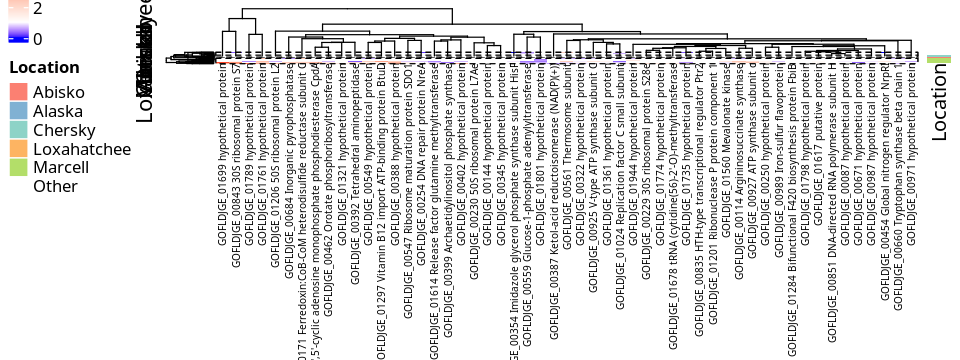

In [138]:
location2 = rowAnnotation(Location = metadata$location,
    col = list(Location = c('Chersky'='#8DD3C7',
                       'Other'='white',
                       'Alaska'='#80B1D3',
                       'Marcell'='#B3DE69',
                       'Loxahatchee'='#FDB462',
                       'Abisko'='#FB8072')))

test <- Heatmap(t(e2d_pfam), col=col_fun3,
                    name = "dN/dS", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 6),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    split=metadata$location
       )

draw(test+location2, heatmap_legend_side = "left", annotation_legend_side = "left")



# ha2 = rowAnnotation(foo=foo,
#                 #cn=anno_text(cn, rot=0, just="right", which="row"),
#                 annotation_height=unit.c(unit(5, "mm"), max_text_width(cn)))

# draw(Heatmap(t(mat), split=foo, show_row_names=TRUE) + ha2, heatmap_legend_side="left", annotation_legend_side="left")

Warning message:
“The input is a data frame, convert it to a matrix.”


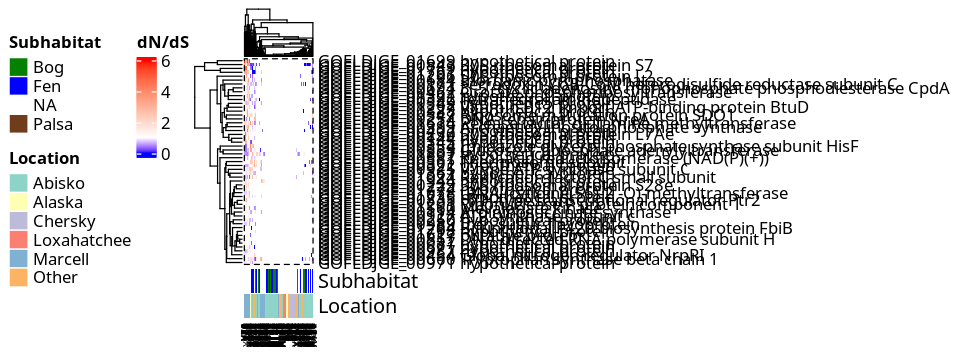

In [139]:
location2 = HeatmapAnnotation(Location = metadata$location,
    col = list(Location = c('Chersky'='#8DD3C7',
                       'Other'='white',
                       'Alaska'='#80B1D3',
                       'Marcell'='#B3DE69',
                       'Loxahatchee'='#FDB462',
                       'Abisko'='#FB8072')))


    plot <- Heatmap(e2d_pfam, col=col_fun3,
                    name = "dN/dS", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 6),
                    bottom_annotation = c(subhab,location),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    cluster_rows = TRUE,
                    cluster_columns = TRUE
               )

draw(plot, heatmap_legend_side = "left", annotation_legend_side = "left")


In [140]:
nrow(e2d_pfam)
nrow(metadata)

head(e2d_pfam)
head(metadata)

[1] 53

[1] 208

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GOFLDJGE_00087 hypothetical protein,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1.0000000,1,1,1,1,1,1
GOFLDJGE_00114 Argininosuccinate synthase,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1.0000000,1,1,1,1,1,1
GOFLDJGE_00144 hypothetical protein,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1.0000000,1,1,1,1,1,1
GOFLDJGE_00171 Ferredoxin:CoB-CoM heterodisulfide reductase subunit C,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,0.2941154,1,1,1,1,1,1
GOFLDJGE_00229 30S ribosomal protein S28e,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1.0000000,1,1,1,1,1,1
GOFLDJGE_00230 50S ribosomal protein L7Ae,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1.0000000,1,1,1,1,1,1


SampleID,1,2,3,4,5,6,7,8,9,⋯,model,sample_name,taxon_name,location,type,V1,Genome,value,sample_name_fixed,log10_abundance
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>
1,0.9999068,1.0000000,0.9999976,1.0000000,0.9999990,0.9999995,0.9999971,1.0000000,0.9999985,⋯,Illumina HiSeq 4000,Metagenome,permafrost,Chersky,NA,1,GCA_003139855.1_20110800_S2M_genomic,0.1990246,Metagenome,-0.5549503
2,1.0000000,0.9999849,0.9999995,1.0000000,0.9999995,0.9999995,0.9999985,1.0000000,1.0000000,⋯,Illumina HiSeq 4000,Metagenome,permafrost,Chersky,NA,2,GCA_003139855.1_20110800_S2M_genomic,0.0000000,Metagenome,-0.5642387
3,0.9999976,0.9999995,0.9998771,0.9999990,0.9999985,0.9999990,0.9999893,0.9999966,0.9999981,⋯,Illumina HiSeq 4000,Metagenome,permafrost,Chersky,NA,3,GCA_003139855.1_20110800_S2M_genomic,0.0000000,Metagenome,-0.5642387
4,1.0000000,1.0000000,0.9999990,0.9999922,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,⋯,Illumina HiSeq 4000,Metagenome,permafrost,Chersky,NA,4,GCA_003139855.1_20110800_S2M_genomic,0.0000000,Metagenome,-0.5642387
5,0.9999990,0.9999995,0.9999985,1.0000000,0.9999757,1.0000000,0.9999990,1.0000000,0.9999990,⋯,Illumina HiSeq 4000,Metagenome,permafrost,Chersky,NA,5,GCA_003139855.1_20110800_S2M_genomic,0.0000000,Metagenome,-0.5642387
6,0.9999995,0.9999995,0.9999990,1.0000000,1.0000000,0.9999524,1.0000000,1.0000000,1.0000000,⋯,Illumina HiSeq 4000,Metagenome,permafrost,Chersky,NA,6,GCA_003139855.1_20110800_S2M_genomic,0.1125413,Metagenome,-0.5589864
